In [210]:
import pandas as pd
import geopandas as gp
import os
import math
import pdv_functions as pdv
import numpy as np
import re
from functools import reduce
from collections import Counter

Election results from Virginia Department of Elections (https://historical.elections.virginia.gov/)

Verifying Data Here: https://apps.elections.virginia.gov/SBE_CSV/ELECTIONS/ELECTIONRESULTS/2020/

In [211]:
path_list = [ 'Virginia_Elections_Database__2020_President_General_Election_including_precincts.csv',
              'Virginia_Elections_Database__2020_U_S_Senate_General_Election_including_precincts.csv',
    'Virginia_Elections_Database__2020_U_S_House_General_Election_District_3_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_10_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_7_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_8_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_4_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_9_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_6_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_11_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_2_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_1_including_precincts.csv',
 'Virginia_Elections_Database__2020_U_S_House_General_Election_District_5_including_precincts.csv']

In [212]:
def get_cd(name):
    
    if "CD" not in name:
        return_val = name.split("-:-")[0]
    else:
        return_val = name.split("-:-")[0]+ " CD (" + re.findall("(?<=CD ).*[^\)]", name)[0] + ")"
    return return_val

split_counties = {'Bedford County',
 'Chesapeake City',
 'Chesterfield County',
 'Fairfax County',
 'Fauquier County',
 'Hampton City',
 'Henrico County',
 'Henry County',
 'James City County',
 'Newport News City',
 'Norfolk City',
 'Prince George County',
 'Prince William County',
 'Richmond City',
 'Roanoke County',
 'Spotsylvania County',
 'Suffolk City'}

In [213]:
path = "./raw-from-source/Election_Results/"

#file_dict = {}
file_list = []
for file in path_list:
    
    
    # Need to treat the two statewide races differently
    if "District" not in file:
        print(file)
        test_load = pd.read_csv(path+file)
        print(test_load.head())
        header = list(test_load.columns)
        party = list(test_load.iloc[0].values)
        
        if file == "President" in file:
            race_id = "PRE"
        elif file == "Senate" in file:
            race_id = "USS"
        else:
            race_id = file.split("_")[-5]
        
        listname = ["" if x!=x else "-:-"+x+"-:-"+race_id for x in party]
        
        new_cols = [i + j for i, j in zip(header, listname)]
        test_load.columns = new_cols
        test_load.rename(columns = {"All Others":"All Others"+"-:-"+race_id}, inplace = True)
        test_load.drop(0, axis = 0, inplace = True)
        test_load.reset_index(inplace = True, drop = True)
        test_load = test_load[test_load["County/City"]!="TOTALS"]
        test_load["join_col"] = test_load["County/City"] + "-:-" + test_load["Pct"]
        #print([i for i in list(test_load["join_col"].unique()) if i not in full_pct_list])

        allocate_races = [i for i in test_load.columns if i not in ['County/City', 'Ward', 'Pct', 'Total Votes Cast', 'join_col']]

        
        for val in allocate_races:
            test_load[val] = test_load[val].astype(str).str.replace(",","")
            test_load[val] = test_load[val].astype(float)
            test_load[val] = test_load[val].astype(int)
        
        test_load_abs = test_load[test_load["join_col"].str.contains("Absentee") | test_load["join_col"].str.contains("Provisional")]
        test_load_prec = test_load[~(test_load["join_col"].str.contains("Absentee") | test_load["join_col"].str.contains("Provisional"))]
        
        split_counties = set([i.split("-:-")[0] for i in test_load_abs["join_col"].unique() if "CD" in i ])
        
        
        test_load["allocate_col"] = test_load["join_col"].apply(lambda x: get_cd(x))
        #test_load_prec = pdv.allocate_absentee(test_load_prec, test_load_abs, allocate_races,"County/City")
        
        test_load_abs = test_load[test_load["join_col"].str.contains("Absentee") | test_load["join_col"].str.contains("Provisional")]
        test_load_prec = test_load[~(test_load["join_col"].str.contains("Absentee") | test_load["join_col"].str.contains("Provisional"))]
        
        test_load_prec = pdv.allocate_absentee(test_load_prec, test_load_abs, allocate_races,"allocate_col")

        if file != "Virginia_Elections_Database__2020_President_General_Election_including_precincts.csv":
            test_load_prec.drop(["County/City", "Pct", "Total Votes Cast", "Ward"],axis = 1, inplace = True)
         
        if max(test_load_prec["join_col"].value_counts(dropna = False)) != 1:
            raise ValueError

        file_list.append(test_load_prec)

va_20_state_level = reduce(lambda x, y: pd.merge(x, y), file_list)
    
        
    #print(test_load.head(2))

Virginia_Elections_Database__2020_President_General_Election_including_precincts.csv
       County/City Ward                   Pct Joseph Robinette Biden, Jr  \
0              NaN  NaN                   NaN                 Democratic   
1  Accomack County    -    101 - Chincoteague                        229   
2  Accomack County    -        201 - Atlantic                         88   
3  Accomack County    -  202 - Greenbackville                        141   
4  Accomack County    -      301 - New Church                        277   

  Donald J. Trump Jo Jorgensen All Others Total Votes Cast  
0      Republican  Libertarian        NaN              NaN  
1           1,072           19          1            1,321  
2             435            7          1              531  
3             723           12          0              876  
4             442            9          1              729  


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:270: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:272: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numer

Virginia_Elections_Database__2020_U_S_Senate_General_Election_including_precincts.csv
       County/City Ward                   Pct Mark Robert Warner  \
0              NaN  NaN                   NaN         Democratic   
1  Accomack County    -    101 - Chincoteague                272   
2  Accomack County    -        201 - Atlantic                106   
3  Accomack County    -  202 - Greenbackville                160   
4  Accomack County    -      301 - New Church                298   

  Daniel Mac Arthur Gade All Others Total Votes Cast  
0             Republican        NaN              NaN  
1                  1,032          1            1,305  
2                    425          0              531  
3                    696          0              856  
4                    421          1              720  


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

In [214]:
file_list

[          County/City Ward                   Pct  \
 0     Accomack County    -    101 - Chincoteague   
 1     Accomack County    -        201 - Atlantic   
 2     Accomack County    -  202 - Greenbackville   
 3     Accomack County    -      301 - New Church   
 4     Accomack County    -          401 - Bloxom   
 ...               ...  ...                   ...   
 2768      York County    -   401 - Harwoods Mill   
 2769      York County    -            402 - Dare   
 2770      York County    -         403 - Grafton   
 2771      York County    -            501 - Tabb   
 2772      York County    -          502 - Bethel   
 
       Joseph Robinette Biden, Jr-:-Democratic-:-President  \
 0                                                   838     
 1                                                   322     
 2                                                   516     
 3                                                  1013     
 4                                                  

In [215]:
va_20_state_level_original = va_20_state_level.copy(deep = True)

In [216]:
vest_va_20 = gp.read_file("./raw-from-source/VEST/va_2020_clean/va_2020_clean.shp")

In [217]:
vest_va_20["join_col"] = vest_va_20["LOCALITY"]+"-:-"+vest_va_20["VTDST"].astype(int).astype(str)+" - "+vest_va_20["PRECINCT"]

In [218]:
vest_va_20["join_col"]

0             Accomack County-:-101 - Chincoteague
1                 Accomack County-:-201 - Atlantic
2           Accomack County-:-202 - Greenbackville
3               Accomack County-:-301 - New Church
4                   Accomack County-:-401 - Bloxom
                           ...                    
2472    Suffolk City-:-302 - John F Kennedy (CD 4)
2473       Suffolk City-:-504 - Lake Cohoon (CD 3)
2474    Suffolk City-:-302 - John F Kennedy (CD 3)
2475                 Fairfax County-:-712 - Shreve
2476            Fairfax County-:-713 - Timber Lane
Name: join_col, Length: 2477, dtype: object

In [219]:
va_20_state_level["join_col"]

0         Accomack County-:-101 - Chincoteague
1             Accomack County-:-201 - Atlantic
2       Accomack County-:-202 - Greenbackville
3           Accomack County-:-301 - New Church
4               Accomack County-:-401 - Bloxom
                         ...                  
2471         York County-:-401 - Harwoods Mill
2472                  York County-:-402 - Dare
2473               York County-:-403 - Grafton
2474                  York County-:-501 - Tabb
2475                York County-:-502 - Bethel
Name: join_col, Length: 2476, dtype: object

In [220]:
va_20_state_level["join_col"] = va_20_state_level["join_col"].str.upper()
vest_va_20["join_col"] = vest_va_20["join_col"].str.upper()

In [221]:
vest_va_20_original = vest_va_20.copy(deep = True)

In [222]:
vest_va_20_original["UNIQUE_ID"] = vest_va_20["join_col"]

In [223]:
dup_list = ['SUFFOLK CITY-:-504 - LAKE COHOON',
 'NEWPORT NEWS CITY-:-211 - PALMER',
 'PRINCE WILLIAM COUNTY-:-112 - BURKE-NICKENS',
 'PRINCE WILLIAM COUNTY-:-110 - BUCKLAND MILLS',
 'NORFOLK CITY-:-104 - TITUSTOWN',
 'PRINCE WILLIAM COUNTY-:-210 - PENN',
 'HENRY COUNTY-:-304 - MOUNT OLIVET',
 'SPOTSYLVANIA COUNTY-:-704 - GAYLE',
 'SPOTSYLVANIA COUNTY-:-703 - FAIRVIEW',
 'SPOTSYLVANIA COUNTY-:-702 - BRENTS MILL',
 'HAMPTON CITY-:-215 - TYLER',
 'HENRY COUNTY-:-505 - DYERS STORE',
 'PRINCE WILLIAM COUNTY-:-312 - TRIANGLE',
 'SPOTSYLVANIA COUNTY-:-402 - PARKSIDE',
 'JAMES CITY COUNTY-:-504 - ROBERTS D',
 'PRINCE WILLIAM COUNTY-:-609 - KING',
 'NEWPORT NEWS CITY-:-218 - KILN CREEK',
 'SUFFOLK CITY-:-302 - JOHN F KENNEDY',
 'SUFFOLK CITY-:-404 - BOOKER T WASHINGTON',
 'FAIRFAX COUNTY-:-513 - SAINT ALBANS',
 'SUFFOLK CITY-:-602 - OLDE TOWNE',
 'SPOTSYLVANIA COUNTY-:-103 - TRAVELERS REST',
 'JAMES CITY COUNTY-:-202 - JAMESTOWN B']

In [224]:
def remove_cd(text):
    if "(CD" in text:
        print(text)
        index = text.find(" (CD ")
        print(text[:index].strip())
        if text[:index].strip() in dup_list:
            return text
        else:
            return text[:index].strip()
    else:
        return text

In [225]:
ser = va_20_state_level["join_col"].value_counts()

In [226]:
list(ser[ser > 1].index)

[]

In [227]:
va_20_state_level["join_col"] = va_20_state_level["join_col"].apply(lambda x: remove_cd(x))

BEDFORD COUNTY-:-101 - GOODVIEW ELEM SCHOOL (CD 5)
BEDFORD COUNTY-:-101 - GOODVIEW ELEM SCHOOL
BEDFORD COUNTY-:-102 - HARDY VOL FIRE CO (CD 5)
BEDFORD COUNTY-:-102 - HARDY VOL FIRE CO
BEDFORD COUNTY-:-103 - CHAMBLISSBURG BAPTIST CHURCH (CD 5)
BEDFORD COUNTY-:-103 - CHAMBLISSBURG BAPTIST CHURCH
BEDFORD COUNTY-:-104 - STEWARTSVILLE RESCUE SQUAD (CD 5)
BEDFORD COUNTY-:-104 - STEWARTSVILLE RESCUE SQUAD
BEDFORD COUNTY-:-201 - BEDFORD CHRISTIAN CHURCH (CD 5)
BEDFORD COUNTY-:-201 - BEDFORD CHRISTIAN CHURCH
BEDFORD COUNTY-:-202 - STAUNTON RIVER HIGH SCHOOL (CD 5)
BEDFORD COUNTY-:-202 - STAUNTON RIVER HIGH SCHOOL
BEDFORD COUNTY-:-203 - MONETA ELEM SCHOOL (CD 5)
BEDFORD COUNTY-:-203 - MONETA ELEM SCHOOL
BEDFORD COUNTY-:-204 - QUAKER BAPTIST CHURCH (CD 5)
BEDFORD COUNTY-:-204 - QUAKER BAPTIST CHURCH
BEDFORD COUNTY-:-205 - SAUNDERS VOL FIRE CO (CD 5)
BEDFORD COUNTY-:-205 - SAUNDERS VOL FIRE CO
BEDFORD COUNTY-:-301 - NEW LONDON ACADEMY (CD 6)
BEDFORD COUNTY-:-301 - NEW LONDON ACADEMY
BEDFORD COUNTY

In [228]:
id_update_dict = {'ALBEMARLE COUNTY-:-407 - BISCUIT RUN':'ALBEMARLE COUNTY-:-499 - BISCUIT RUN',
'ALBEMARLE COUNTY-:-507 - PANTOPS':'ALBEMARLE COUNTY-:-599 - PANTOPS',
'ALLEGHANY COUNTY-:-101 - ARRITT':'ALLEGHANY COUNTY-:-5101 - ARRITT',
'ALLEGHANY COUNTY-:-103 - DAMERON':'ALLEGHANY COUNTY-:-5103 - DAMERON',
'ALLEGHANY COUNTY-:-201 - HUMPBACK BRIDGE':'ALLEGHANY COUNTY-:-5201 - HUMPBACK BRIDGE',
'ALLEGHANY COUNTY-:-202 - DOLLY ANN':'ALLEGHANY COUNTY-:-5202 - DOLLY ANN',
'ALLEGHANY COUNTY-:-301 - CALLAGHAN':'ALLEGHANY COUNTY-:-5301 - CALLAGHAN',
'ALLEGHANY COUNTY-:-302 - GRIFFITH':'ALLEGHANY COUNTY-:-5302 - GRIFFITH',
'ALLEGHANY COUNTY-:-401 - LOW MOOR':'ALLEGHANY COUNTY-:-5401 - LOW MOOR',
'ALLEGHANY COUNTY-:-402 - JACKSON HEIGHTS':'ALLEGHANY COUNTY-:-5402 - JACKSON HEIGHTS',
'ALLEGHANY COUNTY-:-501 - IRON GATE':'ALLEGHANY COUNTY-:-5501 - IRON GATE',
'ALLEGHANY COUNTY-:-502 - PETERS SWITCH':'ALLEGHANY COUNTY-:-5502 - PETERS SWITCH',
'ALLEGHANY COUNTY-:-601 - DISTRICT 1':'ALLEGHANY COUNTY-:-5601 - DISTRICT 1',
'ALLEGHANY COUNTY-:-701 - DISTRICT 2':'ALLEGHANY COUNTY-:-5701 - DISTRICT 2',
'BATH COUNTY-:-101 - WARM SPRINGS':'BATH COUNTY-:-17101 - WARM SPRINGS',
'BATH COUNTY-:-102 - MOUNTAIN GROVE':'BATH COUNTY-:-17102 - MOUNTAIN GROVE',
'BATH COUNTY-:-201 - HOT SPRINGS':'BATH COUNTY-:-17201 - HOT SPRINGS',
'BATH COUNTY-:-301 - FAIRVIEW':'BATH COUNTY-:-17301 - FAIRVIEW',
'BATH COUNTY-:-302 - BURNSVILLE':'BATH COUNTY-:-17302 - BURNSVILLE',
'BATH COUNTY-:-401 - MILLBORO':'BATH COUNTY-:-17401 - MILLBORO',
'BATH COUNTY-:-501 - HEALING SPRINGS':'BATH COUNTY-:-17501 - HEALING SPRINGS',
'BUCHANAN COUNTY-:-102 - BLACKEY':'BUCHANAN COUNTY-:-27102 - BLACKEY',
'BUCHANAN COUNTY-:-103 - HURLEY':'BUCHANAN COUNTY-:-27103 - HURLEY',
'BUCHANAN COUNTY-:-201 - GRASSY':'BUCHANAN COUNTY-:-27201 - GRASSY',
'BUCHANAN COUNTY-:-202 - BULL':'BUCHANAN COUNTY-:-27202 - BULL',
'BUCHANAN COUNTY-:-203 - ROCKLICK':'BUCHANAN COUNTY-:-27203 - ROCKLICK',
'BUCHANAN COUNTY-:-301 - SLATE':'BUCHANAN COUNTY-:-27301 - SLATE',
'BUCHANAN COUNTY-:-302 - NORTH GRUNDY':'BUCHANAN COUNTY-:-27302 - NORTH GRUNDY',
'BUCHANAN COUNTY-:-403 - SOUTH GRUNDY':'BUCHANAN COUNTY-:-27403 - SOUTH GRUNDY',
'BUCHANAN COUNTY-:-404 - OAKWOOD':'BUCHANAN COUNTY-:-27404 - OAKWOOD',
'BUCHANAN COUNTY-:-501 - PRATER':'BUCHANAN COUNTY-:-27501 - PRATER',
'BUCHANAN COUNTY-:-502 - FOX':'BUCHANAN COUNTY-:-27502 - FOX',
'BUCHANAN COUNTY-:-503 - VANSANT':'BUCHANAN COUNTY-:-27503 - VANSANT',
'BUCHANAN COUNTY-:-601 - COUNCIL':'BUCHANAN COUNTY-:-27601 - COUNCIL',
'BUCHANAN COUNTY-:-602 - GARDEN':'BUCHANAN COUNTY-:-27602 - GARDEN',
'BUCHANAN COUNTY-:-603 - HURRICANE':'BUCHANAN COUNTY-:-27603 - HURRICANE',
'BUCHANAN COUNTY-:-701 - WHITEWOOD':'BUCHANAN COUNTY-:-27701 - WHITEWOOD',
'BUCHANAN COUNTY-:-702 - CONTRARY':'BUCHANAN COUNTY-:-27702 - CONTRARY',
'BUCKINGHAM COUNTY-:-101 - NEW CANTON':'BUCKINGHAM COUNTY-:-29101 - NEW CANTON',
'BUCKINGHAM COUNTY-:-102 - GEORGIA CREEK':'BUCKINGHAM COUNTY-:-29102 - GEORGIA CREEK',
'BUCKINGHAM COUNTY-:-201 - WHITE HALL':'BUCKINGHAM COUNTY-:-29201 - WHITE HALL',
'BUCKINGHAM COUNTY-:-301 - CURDSVILLE':'BUCKINGHAM COUNTY-:-29301 - CURDSVILLE',
'BUCKINGHAM COUNTY-:-302 - NEW STORE':'BUCKINGHAM COUNTY-:-29302 - NEW STORE',
'BUCKINGHAM COUNTY-:-401 - MAYSVILLE':'BUCKINGHAM COUNTY-:-29401 - MAYSVILLE',
'BUCKINGHAM COUNTY-:-501 - WRIGHTS':'BUCKINGHAM COUNTY-:-29501 - WRIGHTS',
'BUCKINGHAM COUNTY-:-502 - GLENMORE':'BUCKINGHAM COUNTY-:-29502 - GLENMORE',
'BUCKINGHAM COUNTY-:-601 - SLATE RIVER':'BUCKINGHAM COUNTY-:-29601 - SLATE RIVER',
'BUCKINGHAM COUNTY-:-701 - GOLD HILL':'BUCKINGHAM COUNTY-:-29701 - GOLD HILL',
'CRAIG COUNTY-:-201 - AMMENDALE PRECINCT':'CRAIG COUNTY-:-201 - AMMENDALE',
'FAIRFAX COUNTY-:-630- ARMY':'FAIRFAX COUNTY-:-630 - ARMY',
'FAIRFAX COUNTY-:-705 - GRAHAM - GREENWAY':'FAIRFAX COUNTY-:-705 - GRAHAM-GREENWAY',
'FREDERICKSBURG CITY-:-101 - PRECINCT 1 - DISTRICT ONE':'FREDERICKSBURG CITY-:-101 - DISTRICT 1',
'FREDERICKSBURG CITY-:-201 - PRECINCT 1 - DISTRICT TWO':'FREDERICKSBURG CITY-:-201 - DISTRICT 2',
'FREDERICKSBURG CITY-:-301 - PRECINCT 1 - DISTRICT THREE':'FREDERICKSBURG CITY-:-301 - DISTRICT 3',
'FREDERICKSBURG CITY-:-401 - PRECINCT 1 - DISTRICT FOUR':'FREDERICKSBURG CITY-:-401 - DISTRICT 4 - PRECINCT 1',
'FREDERICKSBURG CITY-:-402 - PRECINCT 2 - DISTRICT FOUR':'FREDERICKSBURG CITY-:-402 - DISTRICT 4 - PRECINCT 2',
'HENRY COUNTY-:-101 - BASSETT NUMBER TWO':'HENRY COUNTY-:-101 - BASSETT #2',
'HENRY COUNTY-:-401 - COLLINSVILLE NUMBER 1':'HENRY COUNTY-:-401 - COLLINSVILLE #1',
'HENRY COUNTY-:-404 - COLLINSVILLE NUMBER 2':'HENRY COUNTY-:-404 - COLLINSVILLE #2',
'HENRY COUNTY-:-501 - BASSETT NUMBER ONE':'HENRY COUNTY-:-501 - BASSETT #1',
'JAMES CITY COUNTY-:-104- BERKELEY D':'JAMES CITY COUNTY-:-104 - BERKELEY D',
'LOUDOUN COUNTY-:-126-GOSHEN POST':'LOUDOUN COUNTY-:-126 - GOSHEN POST',
'LOUDOUN COUNTY-:-322-BUFFALO TRAIL':'LOUDOUN COUNTY-:-322 - BUFFALO TRAIL',
'LOUDOUN COUNTY-:-814 - NEWTON - LEE':'LOUDOUN COUNTY-:-814 - NEWTON-LEE',
'LOUISA COUNTY-:-301 - PATRICK HENRY NO 1':'LOUISA COUNTY-:-301 - PATRICK HENRY #1',
'MIDDLESEX COUNTY-:-401- HARMONY VILLAGE':'MIDDLESEX COUNTY-:-401 - HARMONY VILLAGE',
'NORFOLK CITY-:-213 - TAYLOR ELEMENTARY SCHOOL':'NORFOLK CITY-:-213 - TAYLOR ELEMENTARY',
'NOTTOWAY COUNTY-:-101 - PRECINCT 1-1':'NOTTOWAY COUNTY-:-135101 - PRECINCT 1-1',
'NOTTOWAY COUNTY-:-102 - PRECINCT 1-2':'NOTTOWAY COUNTY-:-135102 - PRECINCT 1-2',
'NOTTOWAY COUNTY-:-201 - PRECINCT 2-1':'NOTTOWAY COUNTY-:-135201 - PRECINCT 2-1',
'NOTTOWAY COUNTY-:-202 - PRECINCT 2-2':'NOTTOWAY COUNTY-:-135202 - PRECINCT 2-2',
'NOTTOWAY COUNTY-:-301 - PRECINCT 3-1':'NOTTOWAY COUNTY-:-135301 - PRECINCT 3-1',
'NOTTOWAY COUNTY-:-302 - PRECINCT 3-2':'NOTTOWAY COUNTY-:-135302 - PRECINCT 3-2',
'NOTTOWAY COUNTY-:-401 - PRECINCT 4-1':'NOTTOWAY COUNTY-:-135401 - PRECINCT 4-1',
'NOTTOWAY COUNTY-:-402 - PRECINCT 4-2':'NOTTOWAY COUNTY-:-135402 - PRECINCT 4-2',
'NOTTOWAY COUNTY-:-501 - PRECINCT 5-1':'NOTTOWAY COUNTY-:-135501 - PRECINCT 5-1',
'PITTSYLVANIA COUNTY-:-202- BEARSKIN':'PITTSYLVANIA COUNTY-:-202 - BEARSKIN',
'PORTSMOUTH CITY-:-33- PINECREST BAPTIST CHURCH':'PORTSMOUTH CITY-:-33 - PINECREST BAPTIST CHURCH',
'PORTSMOUTH CITY-:-34- CHURCHLAND BRANCH LIBRARY':'PORTSMOUTH CITY-:-34 - CHURCHLAND BRANCH LIBRARY',
'PORTSMOUTH CITY-:-7- PARK VIEW ELEMENTARY SCHOOL':'PORTSMOUTH CITY-:-7 - PARK VIEW ELEMENTARY SCHOOL',
'PRINCE WILLIAM COUNTY-:-509 - MC COART':'PRINCE WILLIAM COUNTY-:-509 - MCCOART',
'ROANOKE CITY-:-1 -PETERS CREEK':'ROANOKE CITY-:-1 - PETERS CREEK',
'ROANOKE CITY-:-3 -PRESTON PARK':'ROANOKE CITY-:-3 - PRESTON PARK',
'SPOTSYLVANIA COUNTY-:-203 - NI RIVER - ELYS FORD':'SPOTSYLVANIA COUNTY-:-203 - NI RIVER / ELYS FORD',
'WARREN COUNTY-:-402 - TOWN - WEST SHENANDOAH':'WARREN COUNTY-:-402 - TOWN-WEST SHENANDOAH',
'WASHINGTON COUNTY-:-204 WOODLAND HILLS':'WASHINGTON COUNTY-:-204 - WOODLAND HILLS',
'WISE COUNTY-:-103 - GUEST RIVER VOTING PLACE':'WISE COUNTY-:-103 - GUEST RIVER',
'WYTHE COUNTY-:-603 EVERGREEN':'WYTHE COUNTY-:-603 - EVERGREEN'}

In [229]:
va_20_state_level["join_col"] = va_20_state_level["join_col"].map(id_update_dict).fillna(va_20_state_level["join_col"])

In [230]:
va_20_state_level.rename(columns = {'Joseph Robinette Biden, Jr-:-Democratic-:-President':"G20PREDBID",
'Donald J. Trump-:-Republican-:-President':"G20PRERTRU",
'Jo Jorgensen-:-Libertarian-:-President':"G20PRELJOR", 
'All Others-:-President':'G20PREOWRI',
'Mark Robert Warner-:-Democratic-:-Senate':"G20USSDWAR",
'Daniel Mac Arthur Gade-:-Republican-:-Senate':"G20USSRGAD",
'All Others-:-Senate':"G20USSOWRI"}, inplace = True)

In [231]:
shared_races = [i for i in va_20_state_level.columns if "G20" in i]

In [232]:
for val in shared_races:
    va_20_state_level[val] = va_20_state_level[val].fillna(0)
    vest_va_20[val] = vest_va_20[val].fillna(0)

In [233]:
va_20_state_level

,County/City,Ward,Pct,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOWRI,Total Votes Cast,join_col,allocate_col,G20USSDWAR,G20USSRGAD,G20USSOWRI
0,Accomack County,-,101 - Chincoteague,838,1618,29,2,"1,321",ACCOMACK COUNTY-:-101 - CHINCOTEAGUE,Accomack County,916,1563,3
1,Accomack County,-,201 - Atlantic,322,656,11,2,531,ACCOMACK COUNTY-:-201 - ATLANTIC,Accomack County,357,644,0
2,Accomack County,-,202 - Greenbackville,516,1091,18,0,876,ACCOMACK COUNTY-:-202 - GREENBACKVILLE,Accomack County,539,1054,0
3,Accomack County,-,301 - New Church,1013,667,14,2,729,ACCOMACK COUNTY-:-301 - NEW CHURCH,Accomack County,1003,638,2
4,Accomack County,-,401 - Bloxom,307,462,8,0,395,ACCOMACK COUNTY-:-401 - BLOXOM,Accomack County,306,447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,York County,-,401 - Harwoods Mill,801,1503,60,5,702,YORK COUNTY-:-401 - HARWOODS MILL,York County,935,1484,2
2472,York County,-,402 - Dare,959,1625,38,16,766,YORK COUNTY-:-402 - DARE,York County,974,1647,2
2473,York County,-,403 - Grafton,565,792,33,0,393,YORK COUNTY-:-403 - GRAFTON,York County,554,821,0
2474,York County,-,501 - Tabb,1190,1786,65,21,876,YORK COUNTY-:-501 - TABB,York County,1321,1780,2


## Replace Chesapeake City Values

- 35740 - Trump Absentee + Provisional
- 54109 - Biden Absentee + Provisional

- 12,268 Bad Files claimed Biden Votes (I think these are Trump's)
- 22,440 Bad Files claimed Trump votes (I think these are Biden's)


57k vs. 66k

In [234]:
test_join = pd.merge(va_20_state_level, vest_va_20, how = "outer", on = "join_col", indicator = True)
for race in shared_races:
    test_join[race+"_x"] = test_join[race+"_x"].fillna(0)

In [235]:
test_join.to_csv("./combined.csv", index = False)

In [236]:
pdv.precinct_votes_check(test_join, shared_races, False, "join_col", print_level=0)

G20PREDBID ....................................ACCOMACK COUNTY-:-101 - CHINCOTEAGUE (S) ..838  (V)..837 (D):    1
G20USSDWAR ....................................ACCOMACK COUNTY-:-101 - CHINCOTEAGUE (S) ..916  (V)..915 (D):    1
G20PREDBID ........................................ACCOMACK COUNTY-:-201 - ATLANTIC (S) ..322  (V)..321 (D):    1
G20PRERTRU ........................................ACCOMACK COUNTY-:-201 - ATLANTIC (S) ..656  (V)..657 (D):   -1
G20PRERTRU ........................................ACCOMACK COUNTY-:-402 - PARKSLEY (S) ..585  (V)..586 (D):   -1
G20PREDBID .............................................ACCOMACK COUNTY-:-502 - RUE (S) ..362  (V)..363 (D):   -1
G20PREDBID .........................................ACCOMACK COUNTY-:-601 - ACCOMAC (S) ..413  (V)..414 (D):   -1
G20PRERTRU .........................................ACCOMACK COUNTY-:-601 - ACCOMAC (S) ..558  (V)..559 (D):   -1
G20USSDWAR .........................................ACCOMACK COUNTY-:-601 - ACCOMAC (S) 

G20USSDWAR ........................................MIDDLESEX COUNTY-:-102 - URBANNA (S) ..387  (V)..386 (D):    1
G20USSRGAD ........................................MIDDLESEX COUNTY-:-102 - URBANNA (S) ..455  (V)..454 (D):    1
G20USSDWAR .....................................MIDDLESEX COUNTY-:-201 - NEW MARKET (S) ..554  (V)..555 (D):   -1
G20PREDBID ....................................MIDDLESEX COUNTY-:-302 - CHURCH VIEW (S) ..583  (V)..584 (D):   -1
G20PRERTRU .........................................MIDDLESEX COUNTY-:-501 - WILTON (S) ..957  (V)..958 (D):   -1
G20USSRGAD ..................................MONTGOMERY COUNTY-:-101 - PRECINCT A-1 (S) ..913  (V)..914 (D):   -1
G20PRERTRU ..................................MONTGOMERY COUNTY-:-102 - PRECINCT A-2 (S) ..358  (V)..359 (D):   -1
G20PRELJOR ..................................MONTGOMERY COUNTY-:-102 - PRECINCT A-2 (S) ...35  (V)...34 (D):    1
G20PRELJOR ..................................MONTGOMERY COUNTY-:-103 - PRECINCT A-3 (S) 

In [237]:
test_join

,County/City,Ward,Pct,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20PREOWRI_x,Total Votes Cast,join_col,allocate_col,...,PRECINCT,G20PREDBID_y,G20PRERTRU_y,G20PRELJOR_y,G20PREOWRI_y,G20USSDWAR_y,G20USSRGAD_y,G20USSOWRI_y,geometry,_merge
0,Accomack County,-,101 - Chincoteague,838.0,1618.0,29.0,2.0,"1,321",ACCOMACK COUNTY-:-101 - CHINCOTEAGUE,Accomack County,...,Chincoteague,837,1618,29,2,915,1563,3,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42...",both
1,Accomack County,-,201 - Atlantic,322.0,656.0,11.0,2.0,531,ACCOMACK COUNTY-:-201 - ATLANTIC,Accomack County,...,Atlantic,321,657,11,2,357,644,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59...",both
2,Accomack County,-,202 - Greenbackville,516.0,1091.0,18.0,0.0,876,ACCOMACK COUNTY-:-202 - GREENBACKVILLE,Accomack County,...,Greenbackville,516,1091,18,0,539,1054,0,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49...",both
3,Accomack County,-,301 - New Church,1013.0,667.0,14.0,2.0,729,ACCOMACK COUNTY-:-301 - NEW CHURCH,Accomack County,...,New Church,1013,667,14,2,1003,638,2,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64...",both
4,Accomack County,-,401 - Bloxom,307.0,462.0,8.0,0.0,395,ACCOMACK COUNTY-:-401 - BLOXOM,Accomack County,...,Bloxom,307,462,8,0,306,447,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,York County,-,402 - Dare,959.0,1625.0,38.0,16.0,766,YORK COUNTY-:-402 - DARE,York County,...,Dare,959,1625,38,16,975,1648,2,"POLYGON Z ((-76.46356 37.16058 0.00000, -76.46...",both
2473,York County,-,403 - Grafton,565.0,792.0,33.0,0.0,393,YORK COUNTY-:-403 - GRAFTON,York County,...,Grafton,565,792,33,0,554,821,0,"POLYGON Z ((-76.48228 37.16839 0.00000, -76.48...",both
2474,York County,-,501 - Tabb,1190.0,1786.0,65.0,21.0,876,YORK COUNTY-:-501 - TABB,York County,...,Tabb,1190,1787,64,21,1321,1779,2,"POLYGON Z ((-76.41173 37.14816 0.00000, -76.41...",both
2475,York County,-,502 - Bethel,1694.0,1659.0,78.0,13.0,916,YORK COUNTY-:-502 - BETHEL,York County,...,Bethel,1694,1658,78,13,1786,1664,2,"POLYGON Z ((-76.41583 37.09348 0.00000, -76.41...",both


In [238]:
vest_va_20 = vest_va_20[["COUNTYFP", "LOCALITY", "VTDST", "PRECINCT", "join_col", "geometry"]]

In [239]:
test_join = gp.GeoDataFrame(pd.merge(va_20_state_level, vest_va_20, how = "outer", on = "join_col", indicator = True), crs = vest_va_20.crs)
for race in [i for i in va_20_state_level if i[0:3]=="G20"]:
    test_join[race] = test_join[race].fillna(0)

In [240]:
path = "./raw-from-source/Election_Results/"

#file_dict = {}
file_list = []
for file in path_list:
    
    
    # Need to treat the two statewide races differently
    if "District" in file:
        print(file)
        dist_num = file.split("_")[-3]
        test_load = pd.read_csv(path+file)
        header = list(test_load.columns)
        party = list(test_load.iloc[0].values)
        
        if file == "President" in file:
            race_id = "PRE"
        elif file == "Senate" in file:
            race_id = "USS"
        else:
            race_id = file.split("_")[-5]
        
        listname = ["" if x!=x else "-:-"+x+"-:-"+race_id+dist_num for x in party]
        
        new_cols = [i + j for i, j in zip(header, listname)]
        test_load.columns = new_cols
        test_load.rename(columns = {"All Others":"All Others"+"-:-"+race_id+dist_num}, inplace = True)
        test_load.drop(0, axis = 0, inplace = True)
        test_load.reset_index(inplace = True, drop = True)
        test_load = test_load[test_load["County/City"]!="TOTALS"]
                
        test_load["DIST"] = dist_num
        
        test_load["join_col"] = test_load["County/City"] + "-:-" + test_load["Pct"]
        #print([i for i in list(test_load["join_col"].unique()) if i not in full_pct_list])
        
        
        
        #print(test_load[['County/City', 'Ward', 'Pct', 'Total Votes Cast', 'join_col']])
        
        allocate_races = [i for i in test_load.columns if i not in ['County/City', 'Ward', 'Pct', 'Total Votes Cast', 'join_col', "DIST"]]
        #print(allocate_races)
        
        for val in allocate_races:
            test_load[val] = test_load[val].astype(str).str.replace(",","")
            test_load[val] = test_load[val].astype(float)
            test_load[val] = test_load[val].astype(int)
        
        test_load["allocate_col"] = test_load["join_col"].apply(lambda x: get_cd(x))
        
        test_load_abs = test_load[test_load["join_col"].str.contains("Absentee") | test_load["join_col"].str.contains("Provisional")]
        test_load_prec = test_load[~(test_load["join_col"].str.contains("Absentee") | test_load["join_col"].str.contains("Provisional"))]
        
        test_load_prec = pdv.allocate_absentee(test_load_prec, test_load_abs, allocate_races,"allocate_col")    
         
        if max(test_load["join_col"].value_counts(dropna = False)) != 1:
            raise ValueError

        file_list.append(test_load_prec)
    
        
    #print(test_load.head(2))

Virginia_Elections_Database__2020_U_S_House_General_Election_District_3_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:270: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:272: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numer

Virginia_Elections_Database__2020_U_S_House_General_Election_District_10_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_7_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_8_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_4_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_9_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_6_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_11_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_2_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_1_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

Virginia_Elections_Database__2020_U_S_House_General_Election_District_5_including_precincts.csv


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

In [241]:
va_20_cong_level = pd.concat(file_list)

In [242]:
va_20_cong_level["join_col"] = va_20_cong_level["join_col"].str.upper()
ser = va_20_cong_level["join_col"].value_counts()
dup_ids = list(ser[ser > 1].index)
dup_ids

['SPOTSYLVANIA COUNTY-:-702 - BRENTS MILL',
 'JAMES CITY COUNTY-:-202 - JAMESTOWN B',
 'SUFFOLK CITY-:-504 - LAKE COHOON',
 'SUFFOLK CITY-:-404 - BOOKER T WASHINGTON',
 'HENRY COUNTY-:-505 - DYERS STORE',
 'SUFFOLK CITY-:-302 - JOHN F KENNEDY',
 'FAIRFAX COUNTY-:-513 - SAINT ALBANS',
 'PRINCE WILLIAM COUNTY-:-110 - BUCKLAND MILLS',
 'SPOTSYLVANIA COUNTY-:-103 - TRAVELERS REST',
 'HENRY COUNTY-:-304 - MOUNT OLIVET',
 'PRINCE WILLIAM COUNTY-:-609 - KING',
 'HAMPTON CITY-:-215 - TYLER',
 'PRINCE WILLIAM COUNTY-:-112 - BURKE-NICKENS',
 'NEWPORT NEWS CITY-:-218 - KILN CREEK',
 'SPOTSYLVANIA COUNTY-:-402 - PARKSIDE',
 'SPOTSYLVANIA COUNTY-:-704 - GAYLE',
 'NEWPORT NEWS CITY-:-211 - PALMER',
 'JAMES CITY COUNTY-:-504 - ROBERTS D',
 'NORFOLK CITY-:-104 - TITUSTOWN',
 'SPOTSYLVANIA COUNTY-:-703 - FAIRVIEW',
 'SUFFOLK CITY-:-602 - OLDE TOWNE',
 'PRINCE WILLIAM COUNTY-:-210 - PENN',
 'PRINCE WILLIAM COUNTY-:-312 - TRIANGLE']

In [243]:
va_20_cong_level["join_col"] = np.where(va_20_cong_level["join_col"].isin(dup_ids), va_20_cong_level["join_col"]+va_20_cong_level["DIST"].astype(str), va_20_cong_level["join_col"])

In [244]:
test_join.drop("_merge", axis = 1, inplace = True)

In [245]:
update_dict_2 = {'ALBEMARLE COUNTY-:-407 - BISCUIT RUN':'ALBEMARLE COUNTY-:-499 - BISCUIT RUN',
'ALBEMARLE COUNTY-:-507 - PANTOPS':'ALBEMARLE COUNTY-:-599 - PANTOPS',
'ALLEGHANY COUNTY-:-101 - ARRITT':'ALLEGHANY COUNTY-:-5101 - ARRITT',
'ALLEGHANY COUNTY-:-103 - DAMERON':'ALLEGHANY COUNTY-:-5103 - DAMERON',
'ALLEGHANY COUNTY-:-201 - HUMPBACK BRIDGE':'ALLEGHANY COUNTY-:-5201 - HUMPBACK BRIDGE',
'ALLEGHANY COUNTY-:-202 - DOLLY ANN':'ALLEGHANY COUNTY-:-5202 - DOLLY ANN',
'ALLEGHANY COUNTY-:-301 - CALLAGHAN':'ALLEGHANY COUNTY-:-5301 - CALLAGHAN',
'ALLEGHANY COUNTY-:-302 - GRIFFITH':'ALLEGHANY COUNTY-:-5302 - GRIFFITH',
'ALLEGHANY COUNTY-:-401 - LOW MOOR':'ALLEGHANY COUNTY-:-5401 - LOW MOOR',
'ALLEGHANY COUNTY-:-402 - JACKSON HEIGHTS':'ALLEGHANY COUNTY-:-5402 - JACKSON HEIGHTS',
'ALLEGHANY COUNTY-:-501 - IRON GATE':'ALLEGHANY COUNTY-:-5501 - IRON GATE',
'ALLEGHANY COUNTY-:-502 - PETERS SWITCH':'ALLEGHANY COUNTY-:-5502 - PETERS SWITCH',
'ALLEGHANY COUNTY-:-601 - DISTRICT 1':'ALLEGHANY COUNTY-:-5601 - DISTRICT 1',
'ALLEGHANY COUNTY-:-701 - DISTRICT 2':'ALLEGHANY COUNTY-:-5701 - DISTRICT 2',
'BATH COUNTY-:-101 - WARM SPRINGS':'BATH COUNTY-:-17101 - WARM SPRINGS',
'BATH COUNTY-:-102 - MOUNTAIN GROVE':'BATH COUNTY-:-17102 - MOUNTAIN GROVE',
'BATH COUNTY-:-201 - HOT SPRINGS':'BATH COUNTY-:-17201 - HOT SPRINGS',
'BATH COUNTY-:-301 - FAIRVIEW':'BATH COUNTY-:-17301 - FAIRVIEW',
'BATH COUNTY-:-302 - BURNSVILLE':'BATH COUNTY-:-17302 - BURNSVILLE',
'BATH COUNTY-:-401 - MILLBORO':'BATH COUNTY-:-17401 - MILLBORO',
'BATH COUNTY-:-501 - HEALING SPRINGS':'BATH COUNTY-:-17501 - HEALING SPRINGS',
'BUCHANAN COUNTY-:-102 - BLACKEY':'BUCHANAN COUNTY-:-27102 - BLACKEY',
'BUCHANAN COUNTY-:-103 - HURLEY':'BUCHANAN COUNTY-:-27103 - HURLEY',
'BUCHANAN COUNTY-:-201 - GRASSY':'BUCHANAN COUNTY-:-27201 - GRASSY',
'BUCHANAN COUNTY-:-202 - BULL':'BUCHANAN COUNTY-:-27202 - BULL',
'BUCHANAN COUNTY-:-203 - ROCKLICK':'BUCHANAN COUNTY-:-27203 - ROCKLICK',
'BUCHANAN COUNTY-:-301 - SLATE':'BUCHANAN COUNTY-:-27301 - SLATE',
'BUCHANAN COUNTY-:-302 - NORTH GRUNDY':'BUCHANAN COUNTY-:-27302 - NORTH GRUNDY',
'BUCHANAN COUNTY-:-403 - SOUTH GRUNDY':'BUCHANAN COUNTY-:-27403 - SOUTH GRUNDY',
'BUCHANAN COUNTY-:-404 - OAKWOOD':'BUCHANAN COUNTY-:-27404 - OAKWOOD',
'BUCHANAN COUNTY-:-501 - PRATER':'BUCHANAN COUNTY-:-27501 - PRATER',
'BUCHANAN COUNTY-:-502 - FOX':'BUCHANAN COUNTY-:-27502 - FOX',
'BUCHANAN COUNTY-:-503 - VANSANT':'BUCHANAN COUNTY-:-27503 - VANSANT',
'BUCHANAN COUNTY-:-601 - COUNCIL':'BUCHANAN COUNTY-:-27601 - COUNCIL',
'BUCHANAN COUNTY-:-602 - GARDEN':'BUCHANAN COUNTY-:-27602 - GARDEN',
'BUCHANAN COUNTY-:-603 - HURRICANE':'BUCHANAN COUNTY-:-27603 - HURRICANE',
'BUCHANAN COUNTY-:-701 - WHITEWOOD':'BUCHANAN COUNTY-:-27701 - WHITEWOOD',
'BUCHANAN COUNTY-:-702 - CONTRARY':'BUCHANAN COUNTY-:-27702 - CONTRARY',
'BUCKINGHAM COUNTY-:-101 - NEW CANTON':'BUCKINGHAM COUNTY-:-29101 - NEW CANTON',
'BUCKINGHAM COUNTY-:-102 - GEORGIA CREEK':'BUCKINGHAM COUNTY-:-29102 - GEORGIA CREEK',
'BUCKINGHAM COUNTY-:-201 - WHITE HALL':'BUCKINGHAM COUNTY-:-29201 - WHITE HALL',
'BUCKINGHAM COUNTY-:-301 - CURDSVILLE':'BUCKINGHAM COUNTY-:-29301 - CURDSVILLE',
'BUCKINGHAM COUNTY-:-302 - NEW STORE':'BUCKINGHAM COUNTY-:-29302 - NEW STORE',
'BUCKINGHAM COUNTY-:-401 - MAYSVILLE':'BUCKINGHAM COUNTY-:-29401 - MAYSVILLE',
'BUCKINGHAM COUNTY-:-501 - WRIGHTS':'BUCKINGHAM COUNTY-:-29501 - WRIGHTS',
'BUCKINGHAM COUNTY-:-502 - GLENMORE':'BUCKINGHAM COUNTY-:-29502 - GLENMORE',
'BUCKINGHAM COUNTY-:-601 - SLATE RIVER':'BUCKINGHAM COUNTY-:-29601 - SLATE RIVER',
'BUCKINGHAM COUNTY-:-701 - GOLD HILL':'BUCKINGHAM COUNTY-:-29701 - GOLD HILL',
'CRAIG COUNTY-:-201 - AMMENDALE PRECINCT':'CRAIG COUNTY-:-201 - AMMENDALE',
'FAIRFAX COUNTY-:-513 - SAINT ALBANS11':'FAIRFAX COUNTY-:-513 - SAINT ALBANS (CD 11)',
'FAIRFAX COUNTY-:-513 - SAINT ALBANS8':'FAIRFAX COUNTY-:-513 - SAINT ALBANS (CD 8)',
'FAIRFAX COUNTY-:-630- ARMY':'FAIRFAX COUNTY-:-630 - ARMY',
'FAIRFAX COUNTY-:-705 - GRAHAM - GREENWAY':'FAIRFAX COUNTY-:-705 - GRAHAM-GREENWAY',
'FREDERICKSBURG CITY-:-101 - PRECINCT 1 - DISTRICT ONE':'FREDERICKSBURG CITY-:-101 - DISTRICT 1',
'FREDERICKSBURG CITY-:-201 - PRECINCT 1 - DISTRICT TWO':'FREDERICKSBURG CITY-:-201 - DISTRICT 2',
'FREDERICKSBURG CITY-:-301 - PRECINCT 1 - DISTRICT THREE':'FREDERICKSBURG CITY-:-301 - DISTRICT 3',
'FREDERICKSBURG CITY-:-401 - PRECINCT 1 - DISTRICT FOUR':'FREDERICKSBURG CITY-:-401 - DISTRICT 4 - PRECINCT 1',
'FREDERICKSBURG CITY-:-402 - PRECINCT 2 - DISTRICT FOUR':'FREDERICKSBURG CITY-:-402 - DISTRICT 4 - PRECINCT 2',
'HAMPTON CITY-:-215 - TYLER2':'HAMPTON CITY-:-215 - TYLER (CD 2)',
'HAMPTON CITY-:-215 - TYLER3':'HAMPTON CITY-:-215 - TYLER (CD 3)',
'HENRY COUNTY-:-101 - BASSETT NUMBER TWO':'HENRY COUNTY-:-101 - BASSETT #2',
'HENRY COUNTY-:-304 - MOUNT OLIVET5':'HENRY COUNTY-:-304 - MOUNT OLIVET (CD 5)',
'HENRY COUNTY-:-304 - MOUNT OLIVET9':'HENRY COUNTY-:-304 - MOUNT OLIVET (CD 9)',
'HENRY COUNTY-:-401 - COLLINSVILLE NUMBER 1':'HENRY COUNTY-:-401 - COLLINSVILLE #1',
'HENRY COUNTY-:-404 - COLLINSVILLE NUMBER 2':'HENRY COUNTY-:-404 - COLLINSVILLE #2',
'HENRY COUNTY-:-501 - BASSETT NUMBER ONE':'HENRY COUNTY-:-501 - BASSETT #1',
'HENRY COUNTY-:-505 - DYERS STORE5':'HENRY COUNTY-:-505 - DYERS STORE (CD 5)',
'HENRY COUNTY-:-505 - DYERS STORE9':'HENRY COUNTY-:-505 - DYERS STORE (CD 9)',
'JAMES CITY COUNTY-:-104- BERKELEY D':'JAMES CITY COUNTY-:-104 - BERKELEY D',
'JAMES CITY COUNTY-:-202 - JAMESTOWN B1':'JAMES CITY COUNTY-:-202 - JAMESTOWN B (CD 1)',
'JAMES CITY COUNTY-:-202 - JAMESTOWN B2':'JAMES CITY COUNTY-:-202 - JAMESTOWN B (CD 2)',
'JAMES CITY COUNTY-:-504 - ROBERTS D1':'JAMES CITY COUNTY-:-504 - ROBERTS D (CD 1)',
'JAMES CITY COUNTY-:-504 - ROBERTS D2':'JAMES CITY COUNTY-:-504 - ROBERTS D (CD 2)',
'LOUDOUN COUNTY-:-126-GOSHEN POST':'LOUDOUN COUNTY-:-126 - GOSHEN POST',
'LOUDOUN COUNTY-:-322-BUFFALO TRAIL':'LOUDOUN COUNTY-:-322 - BUFFALO TRAIL',
'LOUDOUN COUNTY-:-814 - NEWTON - LEE':'LOUDOUN COUNTY-:-814 - NEWTON-LEE',
'LOUISA COUNTY-:-301 - PATRICK HENRY NO 1':'LOUISA COUNTY-:-301 - PATRICK HENRY #1',
'MIDDLESEX COUNTY-:-401- HARMONY VILLAGE':'MIDDLESEX COUNTY-:-401 - HARMONY VILLAGE',
'NEWPORT NEWS CITY-:-211 - PALMER2':'NEWPORT NEWS CITY-:-211 - PALMER (CD 2)',
'NEWPORT NEWS CITY-:-211 - PALMER3':'NEWPORT NEWS CITY-:-211 - PALMER (CD 3)',
'NEWPORT NEWS CITY-:-218 - KILN CREEK2':'NEWPORT NEWS CITY-:-218 - KILN CREEK (CD 2)',
'NEWPORT NEWS CITY-:-218 - KILN CREEK3':'NEWPORT NEWS CITY-:-218 - KILN CREEK (CD 3)',
'NORFOLK CITY-:-104 - TITUSTOWN2':'NORFOLK CITY-:-104 - TITUSTOWN (CD 2)',
'NORFOLK CITY-:-104 - TITUSTOWN3':'NORFOLK CITY-:-104 - TITUSTOWN (CD 3)',
'NORFOLK CITY-:-213 - TAYLOR ELEMENTARY SCHOOL':'NORFOLK CITY-:-213 - TAYLOR ELEMENTARY',
'NOTTOWAY COUNTY-:-101 - PRECINCT 1-1':'NOTTOWAY COUNTY-:-135101 - PRECINCT 1-1',
'NOTTOWAY COUNTY-:-102 - PRECINCT 1-2':'NOTTOWAY COUNTY-:-135102 - PRECINCT 1-2',
'NOTTOWAY COUNTY-:-201 - PRECINCT 2-1':'NOTTOWAY COUNTY-:-135201 - PRECINCT 2-1',
'NOTTOWAY COUNTY-:-202 - PRECINCT 2-2':'NOTTOWAY COUNTY-:-135202 - PRECINCT 2-2',
'NOTTOWAY COUNTY-:-301 - PRECINCT 3-1':'NOTTOWAY COUNTY-:-135301 - PRECINCT 3-1',
'NOTTOWAY COUNTY-:-302 - PRECINCT 3-2':'NOTTOWAY COUNTY-:-135302 - PRECINCT 3-2',
'NOTTOWAY COUNTY-:-401 - PRECINCT 4-1':'NOTTOWAY COUNTY-:-135401 - PRECINCT 4-1',
'NOTTOWAY COUNTY-:-402 - PRECINCT 4-2':'NOTTOWAY COUNTY-:-135402 - PRECINCT 4-2',
'NOTTOWAY COUNTY-:-501 - PRECINCT 5-1':'NOTTOWAY COUNTY-:-135501 - PRECINCT 5-1',
'PITTSYLVANIA COUNTY-:-202- BEARSKIN':'PITTSYLVANIA COUNTY-:-202 - BEARSKIN',
'PORTSMOUTH CITY-:-33- PINECREST BAPTIST CHURCH':'PORTSMOUTH CITY-:-33 - PINECREST BAPTIST CHURCH',
'PORTSMOUTH CITY-:-34- CHURCHLAND BRANCH LIBRARY':'PORTSMOUTH CITY-:-34 - CHURCHLAND BRANCH LIBRARY',
'PORTSMOUTH CITY-:-7- PARK VIEW ELEMENTARY SCHOOL':'PORTSMOUTH CITY-:-7 - PARK VIEW ELEMENTARY SCHOOL',
'PRINCE WILLIAM COUNTY-:-110 - BUCKLAND MILLS1':'PRINCE WILLIAM COUNTY-:-110 - BUCKLAND MILLS (CD 1)',
'PRINCE WILLIAM COUNTY-:-110 - BUCKLAND MILLS10':'PRINCE WILLIAM COUNTY-:-110 - BUCKLAND MILLS (CD 10)',
'PRINCE WILLIAM COUNTY-:-112 - BURKE-NICKENS1':'PRINCE WILLIAM COUNTY-:-112 - BURKE-NICKENS (CD 1)',
'PRINCE WILLIAM COUNTY-:-112 - BURKE-NICKENS10':'PRINCE WILLIAM COUNTY-:-112 - BURKE-NICKENS (CD 10)',
'PRINCE WILLIAM COUNTY-:-210 - PENN1':'PRINCE WILLIAM COUNTY-:-210 - PENN (CD 1)',
'PRINCE WILLIAM COUNTY-:-210 - PENN11':'PRINCE WILLIAM COUNTY-:-210 - PENN (CD 11)',
'PRINCE WILLIAM COUNTY-:-312 - TRIANGLE1':'PRINCE WILLIAM COUNTY-:-312 - TRIANGLE (CD 1)',
'PRINCE WILLIAM COUNTY-:-312 - TRIANGLE11':'PRINCE WILLIAM COUNTY-:-312 - TRIANGLE (CD 11)',
'PRINCE WILLIAM COUNTY-:-509 - MC COART':'PRINCE WILLIAM COUNTY-:-509 - MCCOART',
'PRINCE WILLIAM COUNTY-:-609 - KING1':'PRINCE WILLIAM COUNTY-:-609 - KING (CD 1)',
'PRINCE WILLIAM COUNTY-:-609 - KING11':'PRINCE WILLIAM COUNTY-:-609 - KING (CD 11)',
'ROANOKE CITY-:-1 -PETERS CREEK':'ROANOKE CITY-:-1 - PETERS CREEK',
'ROANOKE CITY-:-3 -PRESTON PARK':'ROANOKE CITY-:-3 - PRESTON PARK',
'SPOTSYLVANIA COUNTY-:-103 - TRAVELERS REST1':'SPOTSYLVANIA COUNTY-:-103 - TRAVELERS REST (CD 1)',
'SPOTSYLVANIA COUNTY-:-103 - TRAVELERS REST7':'SPOTSYLVANIA COUNTY-:-103 - TRAVELERS REST (CD 7)',
'SPOTSYLVANIA COUNTY-:-203 - NI RIVER - ELYS FORD':'SPOTSYLVANIA COUNTY-:-203 - NI RIVER / ELYS FORD',
'SPOTSYLVANIA COUNTY-:-402 - PARKSIDE1':'SPOTSYLVANIA COUNTY-:-402 - PARKSIDE (CD 1)',
'SPOTSYLVANIA COUNTY-:-402 - PARKSIDE7':'SPOTSYLVANIA COUNTY-:-402 - PARKSIDE (CD 7)',
'SPOTSYLVANIA COUNTY-:-702 - BRENTS MILL1':'SPOTSYLVANIA COUNTY-:-702 - BRENTS MILL (CD 1)',
'SPOTSYLVANIA COUNTY-:-702 - BRENTS MILL7':'SPOTSYLVANIA COUNTY-:-702 - BRENTS MILL (CD 7)',
'SPOTSYLVANIA COUNTY-:-703 - FAIRVIEW1':'SPOTSYLVANIA COUNTY-:-703 - FAIRVIEW (CD 1)',
'SPOTSYLVANIA COUNTY-:-703 - FAIRVIEW7':'SPOTSYLVANIA COUNTY-:-703 - FAIRVIEW (CD 7)',
'SPOTSYLVANIA COUNTY-:-704 - GAYLE1':'SPOTSYLVANIA COUNTY-:-704 - GAYLE (CD 1)',
'SPOTSYLVANIA COUNTY-:-704 - GAYLE7':'SPOTSYLVANIA COUNTY-:-704 - GAYLE (CD 7)',
'SUFFOLK CITY-:-302 - JOHN F KENNEDY3':'SUFFOLK CITY-:-302 - JOHN F KENNEDY (CD 3)',
'SUFFOLK CITY-:-302 - JOHN F KENNEDY4':'SUFFOLK CITY-:-302 - JOHN F KENNEDY (CD 4)',
'SUFFOLK CITY-:-404 - BOOKER T WASHINGTON3':'SUFFOLK CITY-:-404 - BOOKER T WASHINGTON (CD 3)',
'SUFFOLK CITY-:-404 - BOOKER T WASHINGTON4':'SUFFOLK CITY-:-404 - BOOKER T WASHINGTON (CD 4)',
'SUFFOLK CITY-:-504 - LAKE COHOON3':'SUFFOLK CITY-:-504 - LAKE COHOON (CD 3)',
'SUFFOLK CITY-:-504 - LAKE COHOON4':'SUFFOLK CITY-:-504 - LAKE COHOON (CD 4)',
'SUFFOLK CITY-:-602 - OLDE TOWNE3':'SUFFOLK CITY-:-602 - OLDE TOWNE (CD 3)',
'SUFFOLK CITY-:-602 - OLDE TOWNE4':'SUFFOLK CITY-:-602 - OLDE TOWNE (CD 4)',
'WARREN COUNTY-:-402 - TOWN - WEST SHENANDOAH':'WARREN COUNTY-:-402 - TOWN-WEST SHENANDOAH',
'WASHINGTON COUNTY-:-204 WOODLAND HILLS':'WASHINGTON COUNTY-:-204 - WOODLAND HILLS',
'WISE COUNTY-:-103 - GUEST RIVER VOTING PLACE':'WISE COUNTY-:-103 - GUEST RIVER',
'WYTHE COUNTY-:-603 EVERGREEN':'WYTHE COUNTY-:-603 - EVERGREEN'}

In [246]:
va_20_cong_level["join_col"] = va_20_cong_level["join_col"].map(update_dict_2).fillna(va_20_cong_level["join_col"])

In [247]:
col_update_dict = {       'All Others-:-Election11':'GCON11OWRI',
       'Elaine Goodman Luria-:-Democratic-:-Election2':'GCON02DLUR',
       'Scott William Taylor-:-Republican-:-Election2':'GCON02RTAY',
       'David Bruce Foster-:-Independent-:-Election2':'GCON02IFOS',
       'All Others-:-Election2':'GCON02OWRI',
       'Robert Joseph Wittman-:-Republican-:-Election1':'GCON01RWIT',
       'Qasim Rashid-:-Democratic-:-Election1':'GCON01DRAS',
       'All Others-:-Election1':'GCON01OWRI',
       'Robert George Good-:-Republican-:-Election5':'GCON05RGOO',
       'Bryant Cameron Webb-:-Democratic-:-Election5':'GCON05DWEB',
       'All Others-:-Election5':'GCON05OWRI',
    'Robert Cortez Scott-:-Democratic-:-Election3':'GCON03DSCO',
       'John William Collick, Jr-:-Republican-:-Election3':'GCON03RCOL',
       'All Others-:-Election3':'GCON03OWRI',
       'Jennifer Tosini Wexton-:-Democratic-:-Election10':'GCON10DWEX',
       'Aliscia Nicole Andrews-:-Republican-:-Election10':'GCON10RAND',
       'All Others-:-Election10':'GCON10OWRI',
       'Abigail Anne Davis Spanberger-:-Democratic-:-Election7':'GCON07DSPA',
       'Nicholas J. Freitas-:-Republican-:-Election7':'GCON07RFRE',
       'All Others-:-Election7':'GCON07OWRI',
       'Donald Sternoff Beyer, Jr.-:-Democratic-:-Election8':'GCON08DBEY',
       'Jeffrey Alan Jordan-:-Republican-:-Election8':'GCON08RJOR',
       'All Others-:-Election8':'GCON08OWRI',
       'A. Donald McEachin-:-Democratic-:-Election4':'GCON04DMCE',
       'Leon Benjamin, Sr-:-Republican-:-Election4':'GCON04RBEN',
       'All Others-:-Election4':'GCON04OWRI',
       'Howard Morgan Griffith-:-Republican-:-Election9':'GCON09RGRI',
       'All Others-:-Election9':'GCON09OWRI',
       'Benjamin Lee Cline-:-Republican-:-Election6':'GCON06RCLI',
       'Nicholas Anthony Betts-:-Democratic-:-Election6':'GCON06DBET',
       'All Others-:-Election6':'GCON06OWRI',
       'Gerald Edward Connolly-:-Democratic-:-Election11':'GCON11DCON',
       'Manga Alamelu Anantatmula-:-Republican-:-Election11':'GCON11RANA',
}

In [248]:
va_20_cong_level.rename(columns = col_update_dict, inplace = True)

In [249]:
cong_list = list(col_update_dict.values())

In [250]:
va_20_cong_level.drop(["County/City","Ward","Pct","allocate_col", "Total Votes Cast"], axis = 1, inplace = True)

In [251]:
test_join_2 = gp.GeoDataFrame(pd.merge(test_join, va_20_cong_level, how = "outer", on = "join_col", indicator = True), crs = test_join.crs)

In [252]:
test_join_2["_merge"].value_counts()

both          2476
left_only        1
right_only       0
Name: _merge, dtype: int64

In [253]:
races = [i for i in test_join_2.columns if i[0] == "G"]

In [254]:
for race in races:
    test_join_2[race] = test_join_2[race].fillna(0)

In [255]:
test_join_2.rename(columns = {"join_col":"UNIQUE_ID"}, inplace = True)

# Look into Split Precincts

In [256]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if  column_name[0:4] == "GCON":
        level = "CON"
        dist = column_name[4:6]
    elif column_name[0:4] == "SCON":
        level = "SCON"
        dist = column_name[4:6]
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GSU":
        level = "SU"
        dist = column_name[3:5]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_sldu(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SU":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]
        
def contains_scong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SCON":
            return dist_tuple[1]
        

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in test_join_2.iterrows():
    precinct_list = []
    for contest in cong_list:
        if(row[contest]!=0) and ("GSL" in contest or "GCON" in contest or "GSU" in contest or "SCON" in contest):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
sldl_check_list = {i:contains_sldl(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
cong_check_list = {i:contains_cong(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldu_check_list = {i:contains_sldu(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
scong_check_list = {i:contains_scong(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [257]:
test_join_2[test_join_2["DIST"].isna()]

,County/City,Ward,Pct,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOWRI,Total Votes Cast,UNIQUE_ID,allocate_col,...,GCON02RTAY,GCON02IFOS,GCON02OWRI,GCON01RWIT,GCON01DRAS,GCON01OWRI,GCON05RGOO,GCON05DWEB,GCON05OWRI,_merge
2476,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,FAIRFAX COUNTY-:-700 - FAIRFAX COURT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,left_only


## Fill in any n/a values for districts

- Will add these for congress
- For state senate, only half the seats contested, for special cong. only two seats up for election

(38.842839999999995, 38.846835)

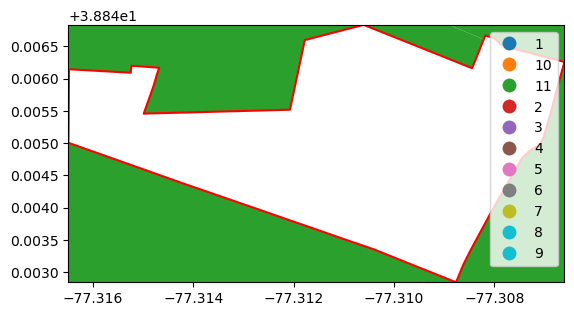

In [258]:
ax = test_join_2.plot(column = "DIST", legend = True)

limit_area = test_join_2[test_join_2["DIST"].isna()]

limit_area.boundary.plot(ax = ax, color = "red")


xlim = ([limit_area.total_bounds[0],  limit_area.total_bounds[2]])
ylim = ([limit_area.total_bounds[1],  limit_area.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [259]:
test_join_2.loc[test_join_2["DIST"].isna(), "DIST"] = "11"

In [260]:
test_join_2.rename(columns = {"DIST":"CONG_DIST"}, inplace = True)

In [261]:
test_join_2.drop("_merge", axis = 1, inplace = True)

In [262]:
va_cong_districts = gp.read_file("./raw-from-source/Districts/va_cong_2016_to_2021/va_cong_2016_to_2021.shp")

In [263]:
filtered_cong_results = test_join_2.dissolve("CONG_DIST")
filtered_cong_results.reset_index(inplace=True, drop=False)

In [264]:
filtered_cong_results["CONG_DIST"]

0      1
1     10
2     11
3      2
4      3
5      4
6      5
7      6
8      7
9      8
10     9
Name: CONG_DIST, dtype: object

In [265]:
va_cong_districts["CONG_DIST"] = va_cong_districts["District_N"].astype(str)

## Compare the district assignments

#### Congress

Checking 11 Districts for differences of greater than 0 km^2

1) For 1 difference in area is 0.9359680705087491
2) For 10 difference in area is 0.6636237436300293
3) For 11 difference in area is 0.33750380787151263
4) For 2 difference in area is 0.313221962831705
5) For 3 difference in area is 0.2831070924036543
6) For 4 difference in area is 0.5164202774520542
7) For 5 difference in area is 1.8546110560771178
8) For 6 difference in area is 1.3649297406374834
9) For 7 difference in area is 1.3334272034045447
10) For 8 difference in area is 0.19117067907942512
11) For 9 difference in area is 1.0306082767427471

Scroll down to see plots of any differences

Of the 11 Districts:

0 Districts w/ a difference of 0 km^2
0 Districts w/ a difference between 0 and .1 km^2
4 Districts w/ a difference between .1 and .5 km^2
3 Districts w/ a difference between .5 and 1 km^2
4 Districts w/ a difference between 1 and 2 km^2
0 Districts w/ a difference between 2 and 5 km^2
0 Districts w/ a difference 

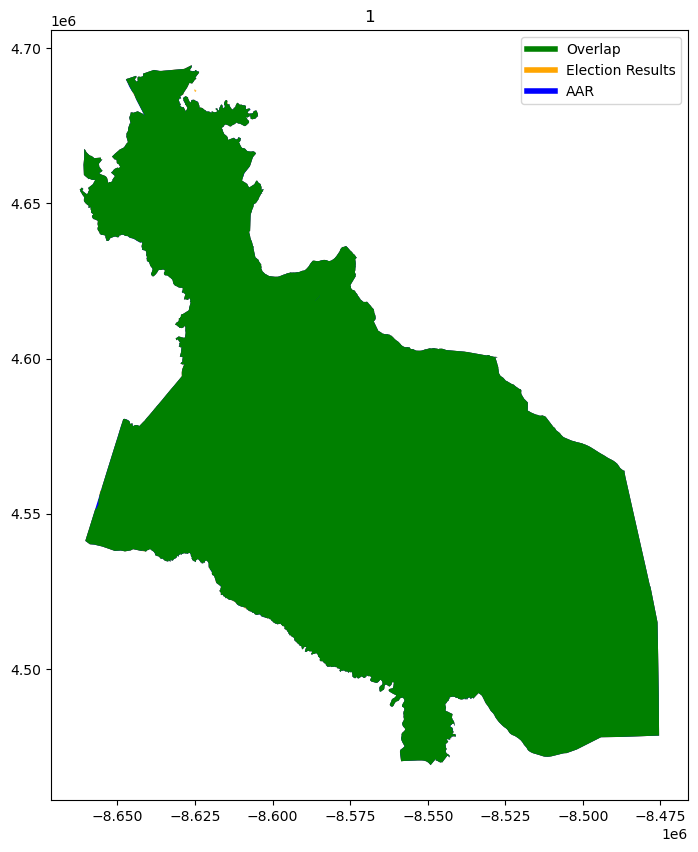

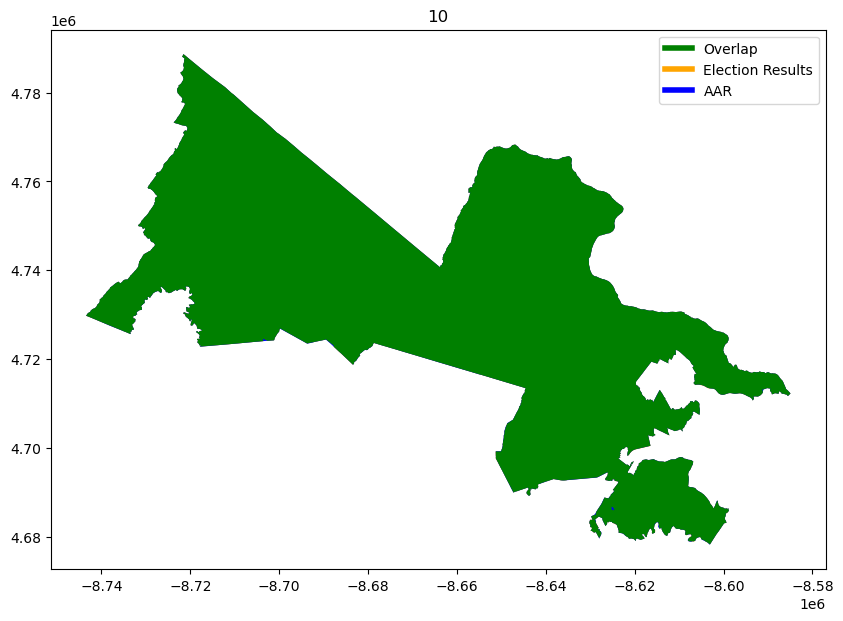

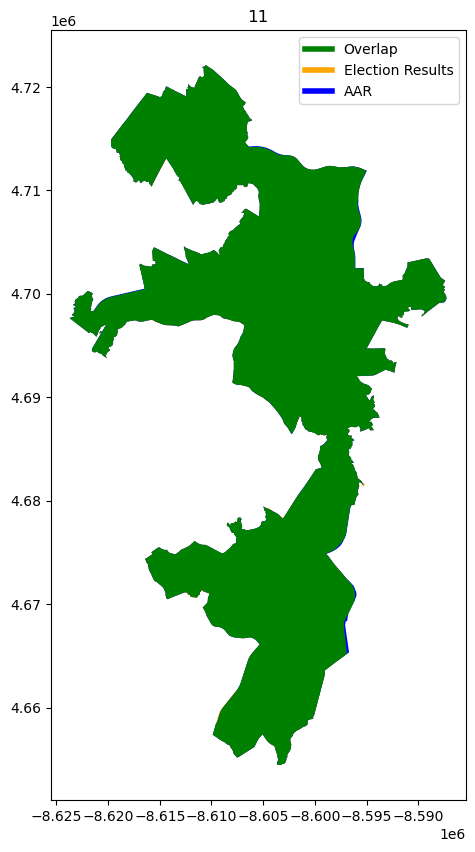

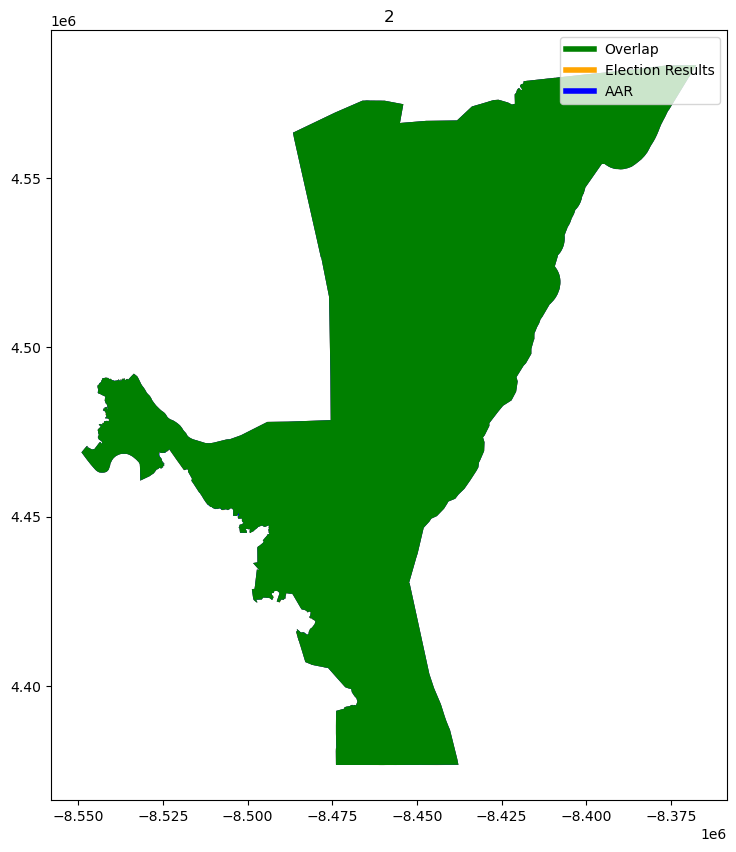

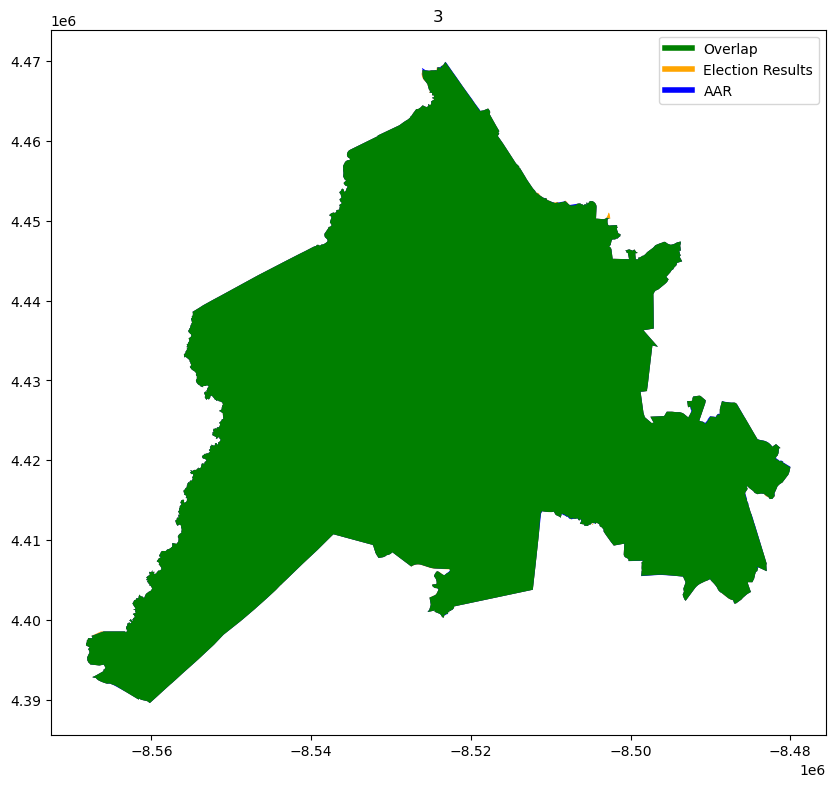

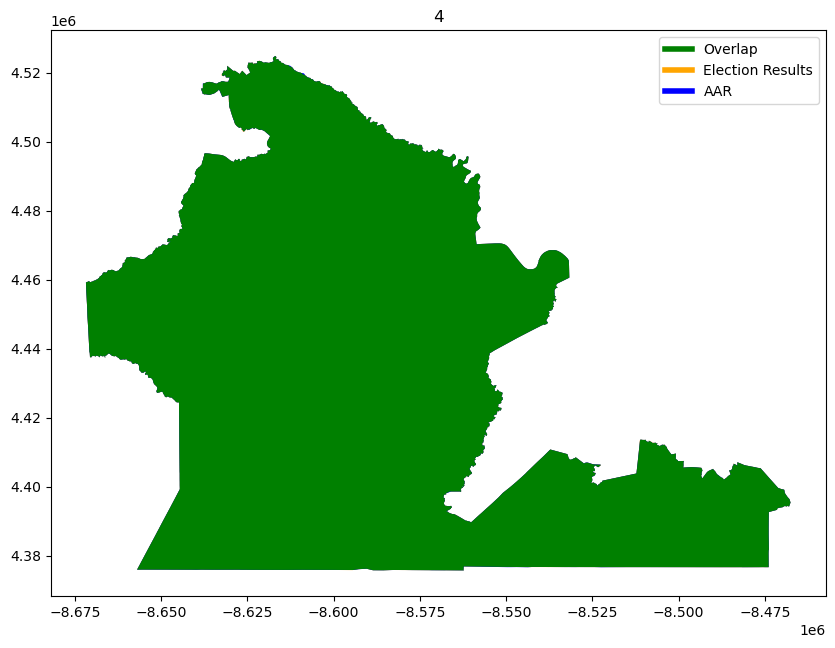

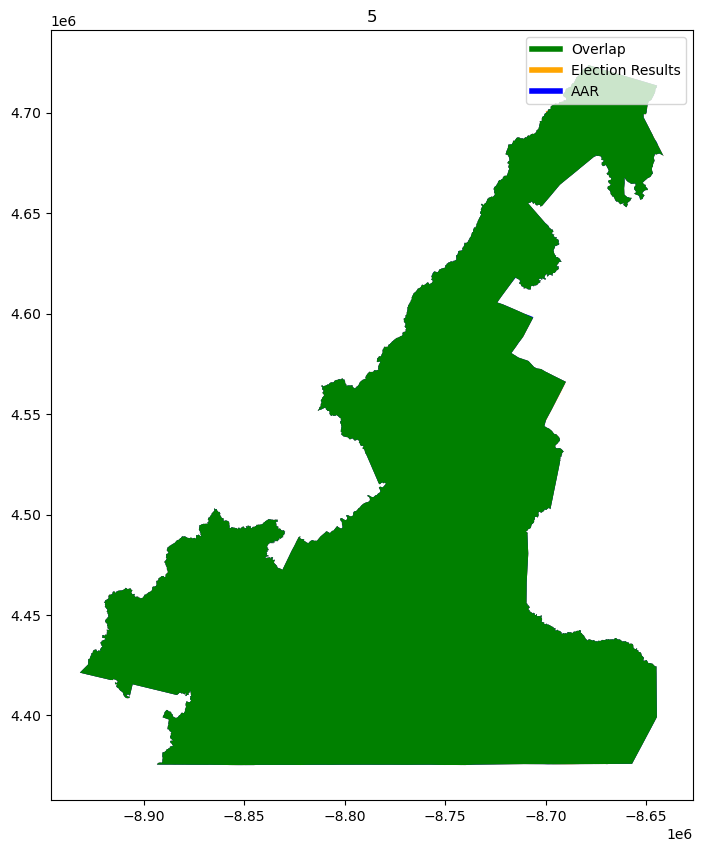

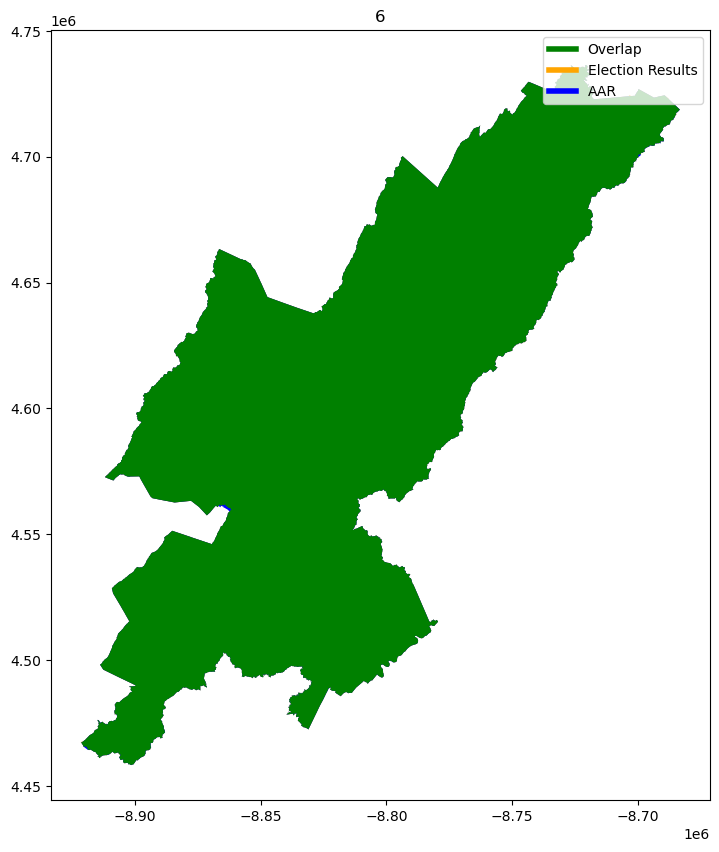

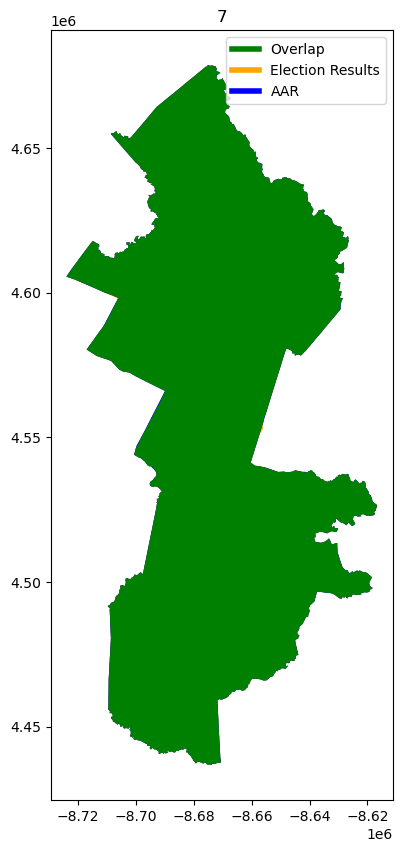

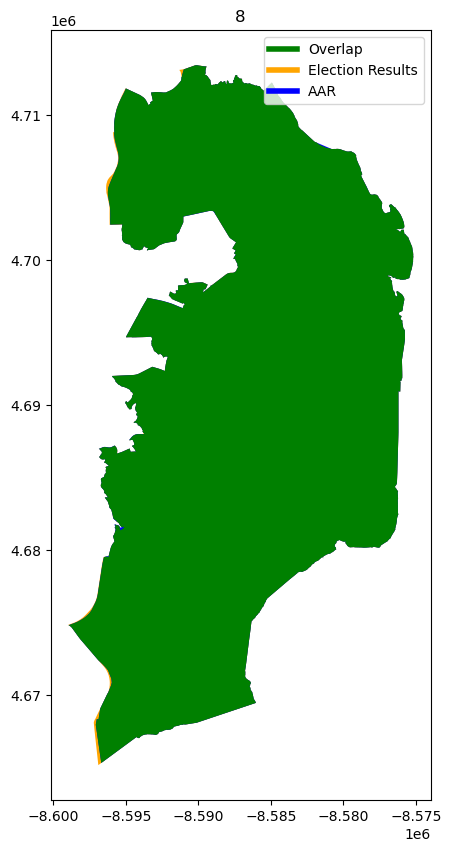

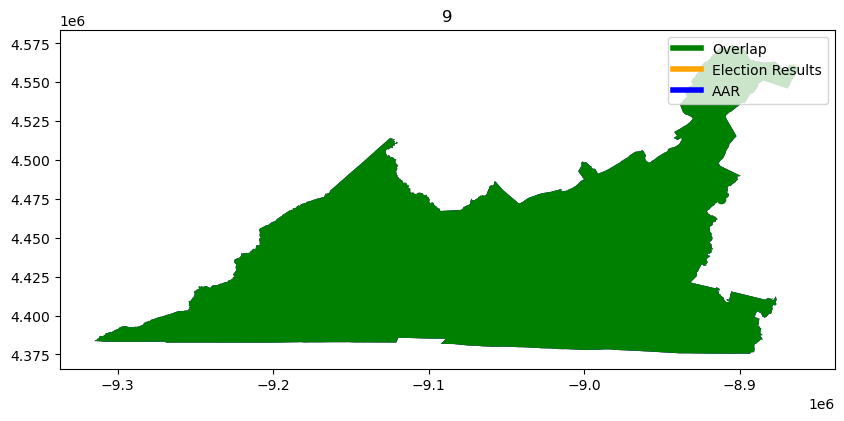

In [266]:
pdv.compare_geometries(filtered_cong_results, va_cong_districts ,"Election Results", "AAR", "CONG_DIST","Districts",area_threshold=0)


## Clean File for Final Export

In [267]:
test_join_2

,County/City,Ward,Pct,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOWRI,Total Votes Cast,UNIQUE_ID,allocate_col,...,GCON02DLUR,GCON02RTAY,GCON02IFOS,GCON02OWRI,GCON01RWIT,GCON01DRAS,GCON01OWRI,GCON05RGOO,GCON05DWEB,GCON05OWRI
0,Accomack County,-,101 - Chincoteague,838.0,1618.0,29.0,2.0,"1,321",ACCOMACK COUNTY-:-101 - CHINCOTEAGUE,Accomack County,...,871.0,1540.0,62.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Accomack County,-,201 - Atlantic,322.0,656.0,11.0,2.0,531,ACCOMACK COUNTY-:-201 - ATLANTIC,Accomack County,...,339.0,624.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Accomack County,-,202 - Greenbackville,516.0,1091.0,18.0,0.0,876,ACCOMACK COUNTY-:-202 - GREENBACKVILLE,Accomack County,...,550.0,1034.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Accomack County,-,301 - New Church,1013.0,667.0,14.0,2.0,729,ACCOMACK COUNTY-:-301 - NEW CHURCH,Accomack County,...,982.0,651.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Accomack County,-,401 - Bloxom,307.0,462.0,8.0,0.0,395,ACCOMACK COUNTY-:-401 - BLOXOM,Accomack County,...,287.0,448.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,York County,-,402 - Dare,959.0,1625.0,38.0,16.0,766,YORK COUNTY-:-402 - DARE,York County,...,940.0,1604.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,York County,-,403 - Grafton,565.0,792.0,33.0,0.0,393,YORK COUNTY-:-403 - GRAFTON,York County,...,565.0,760.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,York County,-,501 - Tabb,1190.0,1786.0,65.0,21.0,876,YORK COUNTY-:-501 - TABB,York County,...,1205.0,1760.0,82.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,York County,-,502 - Bethel,1694.0,1659.0,78.0,13.0,916,YORK COUNTY-:-502 - BETHEL,York County,...,1718.0,1615.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
races_list = [i for i in test_join_2.columns if i[0] =="G"]

In [269]:
races_list.sort()

In [270]:
print(races_list)

['G20PREDBID', 'G20PRELJOR', 'G20PREOWRI', 'G20PRERTRU', 'G20USSDWAR', 'G20USSOWRI', 'G20USSRGAD', 'GCON01DRAS', 'GCON01OWRI', 'GCON01RWIT', 'GCON02DLUR', 'GCON02IFOS', 'GCON02OWRI', 'GCON02RTAY', 'GCON03DSCO', 'GCON03OWRI', 'GCON03RCOL', 'GCON04DMCE', 'GCON04OWRI', 'GCON04RBEN', 'GCON05DWEB', 'GCON05OWRI', 'GCON05RGOO', 'GCON06DBET', 'GCON06OWRI', 'GCON06RCLI', 'GCON07DSPA', 'GCON07OWRI', 'GCON07RFRE', 'GCON08DBEY', 'GCON08OWRI', 'GCON08RJOR', 'GCON09OWRI', 'GCON09RGRI', 'GCON10DWEX', 'GCON10OWRI', 'GCON10RAND', 'GCON11DCON', 'GCON11OWRI', 'GCON11RANA']


In [271]:
vest_va_20_original.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREOWRI', 'G20USSDWAR', 'G20USSRGAD', 'G20USSOWRI',
       'geometry', 'join_col', 'UNIQUE_ID'],
      dtype='object')

In [272]:
test_join_2.columns

Index(['County/City', 'Ward', 'Pct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR',
       'G20PREOWRI', 'Total Votes Cast', 'UNIQUE_ID', 'allocate_col',
       'G20USSDWAR', 'G20USSRGAD', 'G20USSOWRI', 'COUNTYFP', 'LOCALITY',
       'VTDST', 'PRECINCT', 'geometry', 'GCON03DSCO', 'GCON03RCOL',
       'GCON03OWRI', 'CONG_DIST', 'GCON10DWEX', 'GCON10RAND', 'GCON10OWRI',
       'GCON07DSPA', 'GCON07RFRE', 'GCON07OWRI', 'GCON08DBEY', 'GCON08RJOR',
       'GCON08OWRI', 'GCON04DMCE', 'GCON04RBEN', 'GCON04OWRI', 'GCON09RGRI',
       'GCON09OWRI', 'GCON06RCLI', 'GCON06DBET', 'GCON06OWRI', 'GCON11DCON',
       'GCON11RANA', 'GCON11OWRI', 'GCON02DLUR', 'GCON02RTAY', 'GCON02IFOS',
       'GCON02OWRI', 'GCON01RWIT', 'GCON01DRAS', 'GCON01OWRI', 'GCON05RGOO',
       'GCON05DWEB', 'GCON05OWRI'],
      dtype='object')

In [273]:
test_join_2 = test_join_2[["UNIQUE_ID","COUNTYFP",'LOCALITY', 'VTDST', 'PRECINCT']
                                                           +["CONG_DIST"]+races_list+["geometry"]]


In [274]:
chesapeake_grouped

,CONG_DIST,G20PREDBID,G20PRELJOR,G20PREOWRI,G20PRERTRU,G20USSDWAR,G20USSOWRI,G20USSRGAD,GCON01DRAS,GCON01OWRI,...,GCON08OWRI,GCON08RJOR,GCON09OWRI,GCON09RGRI,GCON10DWEX,GCON10OWRI,GCON10RAND,GCON11DCON,GCON11OWRI,GCON11RANA
0,3,323.0,8.0,0.0,154.0,320.0,0.0,153.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,384.0,31.0,0.0,282.0,378.0,0.0,300.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modify Chesapeake City Election Results

In [277]:
chesapeake_mod_results = pd.read_csv("./raw-from-source/Election_Results/Chesapeake_City.csv")
chesapeake_mod_results = chesapeake_mod_results[["UNIQUE_ID","COUNTYFP",'LOCALITY', 'VTDST', 'PRECINCT']
                                                           +["CONG_DIST"]+races_list]
chesapeake_mod_results["CONG_DIST"] = chesapeake_mod_results["CONG_DIST"].astype(str)

chesapeake_grouped = test_join_2[test_join_2["LOCALITY"]=="Chesapeake City"].groupby("CONG_DIST").sum()
chesapeake_grouped.reset_index(inplace = True, drop = False)

chesapeake_known_sums = chesapeake_mod_results.groupby("CONG_DIST").sum()
chesapeake_known_sums.reset_index(inplace = True, drop = False)

chesapeake_known_sums["CONG_DIST"] = chesapeake_known_sums["CONG_DIST"].astype(str)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_1443/1423319746.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chesapeake_grouped = test_join_2[test_join_2["LOCALITY"]=="Chesapeake City"].groupby("CONG_DIST").sum()
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_1443/1423319746.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chesapeake_known_sums = chesapeake_mod_results.groupby("CONG_DIST").sum()


In [278]:
for dist in ["3", "4"]:
    for race in races_list:
        print(race)
        print(chesapeake_grouped.loc[chesapeake_grouped["CONG_DIST"]==dist, race].values[0])
        print(chesapeake_known_sums.loc[chesapeake_known_sums["CONG_DIST"]==dist, race].values[0])
        chesapeake_grouped.loc[chesapeake_grouped["CONG_DIST"]==dist, race] = chesapeake_grouped.loc[chesapeake_grouped["CONG_DIST"]==dist, race].values[0] - chesapeake_known_sums.loc[chesapeake_known_sums["CONG_DIST"]==dist, race].values[0]

G20PREDBID
34788.0
34465
G20PRELJOR
884.0
876
G20PREOWRI
200.0
200
G20PRERTRU
19960.0
19806
G20USSDWAR
35843.0
35523
G20USSOWRI
57.0
57
G20USSRGAD
19566.0
19413
GCON01DRAS
0.0
0
GCON01OWRI
0.0
0
GCON01RWIT
0.0
0
GCON02DLUR
0.0
0
GCON02IFOS
0.0
0
GCON02OWRI
0.0
0
GCON02RTAY
0.0
0
GCON03DSCO
35042.0
34687
GCON03OWRI
106.0
106
GCON03RCOL
19860.0
19698
GCON04DMCE
0.0
0
GCON04OWRI
0.0
0
GCON04RBEN
0.0
0
GCON05DWEB
0.0
0
GCON05OWRI
0.0
0
GCON05RGOO
0.0
0
GCON06DBET
0.0
0
GCON06OWRI
0.0
0
GCON06RCLI
0.0
0
GCON07DSPA
0.0
0
GCON07OWRI
0.0
0
GCON07RFRE
0.0
0
GCON08DBEY
0.0
0
GCON08OWRI
0.0
0
GCON08RJOR
0.0
0
GCON09OWRI
0.0
0
GCON09RGRI
0.0
0
GCON10DWEX
0.0
0
GCON10OWRI
0.0
0
GCON10RAND
0.0
0
GCON11DCON
0.0
0
GCON11OWRI
0.0
0
GCON11RANA
0.0
0
G20PREDBID
31589.0
31205
G20PRELJOR
1214.0
1183
G20PREOWRI
253.0
253
G20PRERTRU
38220.0
37938
G20USSDWAR
32286.0
31908
G20USSOWRI
68.0
68
G20USSRGAD
38588.0
38288
GCON01DRAS
0.0
0
GCON01OWRI
0.0
0
GCON01RWIT
0.0
0
GCON02DLUR
0.0
0
GCON02IFOS
0.0
0
GCON02OWRI

In [279]:
chesapeake_grouped

,CONG_DIST,G20PREDBID,G20PRELJOR,G20PREOWRI,G20PRERTRU,G20USSDWAR,G20USSOWRI,G20USSRGAD,GCON01DRAS,GCON01OWRI,...,GCON08OWRI,GCON08RJOR,GCON09OWRI,GCON09RGRI,GCON10DWEX,GCON10OWRI,GCON10RAND,GCON11DCON,GCON11OWRI,GCON11RANA
0,3,323.0,8.0,0.0,154.0,320.0,0.0,153.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,384.0,31.0,0.0,282.0,378.0,0.0,300.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
chesapeake_rdh = test_join_2[test_join_2["LOCALITY"]=="Chesapeake City"].copy(deep = True)

In [281]:
chesapeake_addition = pdv.allocate_absentee(chesapeake_mod_results, chesapeake_grouped, races_list,"CONG_DIST")


/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:270: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:309: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_receiving_votes.loc[:,rem_var]=0.0
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:349: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:371: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:372: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instea

In [282]:
chesapeake_unique_ids = list(test_join_2[test_join_2["LOCALITY"]=="Chesapeake City"]["UNIQUE_ID"].unique())

In [283]:
for val in chesapeake_unique_ids:
    for race in races_list:
        test_join_2.loc[test_join_2["UNIQUE_ID"]==val,race] = chesapeake_addition.loc[chesapeake_addition["UNIQUE_ID"]==val,race].values[0]

In [284]:
updated_vest_check = pd.merge(test_join_2, vest_va_20_original, how = "outer", on="UNIQUE_ID", indicator = True)

In [285]:
pdv.precinct_votes_check(updated_vest_check , shared_races, False, "UNIQUE_ID", print_level=0)

G20PREDBID ....................................ACCOMACK COUNTY-:-101 - CHINCOTEAGUE (S) ..838  (V)..837 (D):    1
G20USSDWAR ....................................ACCOMACK COUNTY-:-101 - CHINCOTEAGUE (S) ..916  (V)..915 (D):    1
G20PREDBID ........................................ACCOMACK COUNTY-:-201 - ATLANTIC (S) ..322  (V)..321 (D):    1
G20PRERTRU ........................................ACCOMACK COUNTY-:-201 - ATLANTIC (S) ..656  (V)..657 (D):   -1
G20PRERTRU ........................................ACCOMACK COUNTY-:-402 - PARKSLEY (S) ..585  (V)..586 (D):   -1
G20PREDBID .............................................ACCOMACK COUNTY-:-502 - RUE (S) ..362  (V)..363 (D):   -1
G20PREDBID .........................................ACCOMACK COUNTY-:-601 - ACCOMAC (S) ..413  (V)..414 (D):   -1
G20PRERTRU .........................................ACCOMACK COUNTY-:-601 - ACCOMAC (S) ..558  (V)..559 (D):   -1
G20USSDWAR .........................................ACCOMACK COUNTY-:-601 - ACCOMAC (S) 

G20USSDWAR ........................................LOUDOUN COUNTY-:-702 - PARK VIEW (S) .1871  (V).1872 (D):   -1
G20PRELJOR ....................................LOUDOUN COUNTY-:-703 - ROLLING RIDGE (S) ...48  (V)...47 (D):    1
G20PRELJOR .....................................LOUDOUN COUNTY-:-705 - FOREST GROVE (S) ...57  (V)...58 (D):   -1
G20PREDBID ...........................................LOUDOUN COUNTY-:-708 - SENECA (S) .1127  (V).1126 (D):    1
G20USSRGAD ...........................................LOUDOUN COUNTY-:-708 - SENECA (S) ..737  (V)..736 (D):    1
G20PREDBID .....................................LOUDOUN COUNTY-:-709 - MIRROR RIDGE (S) .1918  (V).1919 (D):   -1
G20PRERTRU .....................................LOUDOUN COUNTY-:-709 - MIRROR RIDGE (S) ..700  (V)..699 (D):    1
G20PRERTRU .........................................LOUDOUN COUNTY-:-710 - STERLING (S) ..663  (V)..662 (D):    1
G20USSDWAR .........................................LOUDOUN COUNTY-:-710 - STERLING (S) 

In [286]:
if not os.path.exists('./va_gen_20_prec/'):
    os.mkdir('./va_gen_20_prec/')

test_join_2.to_file('./va_gen_20_prec/va_gen_20_st_cong_prec.shp')


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [287]:
# test_join_2.drop("geometry", inplace = True, axis = 1)
# test_join_2.to_csv("rdh_va_file.csv", index = False)

## Check Totals Against Other VA Site

In [288]:
election_results= pd.read_csv("./raw-from-source/Election_Results/2020 November General.csv", index_col=False)

In [289]:
election_results["OfficeTitle"].unique()

array(['Member Town Council - Accomac', 'Member Town Council - Parksley',
       'Member House of Representatives', 'Mayor - Melfa',
       'Mayor - Bloxom', 'Member Town Council - Onley',
       'Member Town Council - Bloxom', 'Member Town Council - Painter',
       'Mayor - Onley', 'President and Vice President', 'Mayor - Accomac',
       'Member Town Council - Melfa', 'Member United States Senate',
       'Mayor - Painter', 'Mayor', 'Member Town Council - Clifton Forge',
       'Member Town Council', 'Member Board of Supervisors',
       'Member Town Council - Amherst', 'Member County Board',
       'Member School Board', 'Mayor - Grottoes',
       'Member Town Council - Craigsville',
       'Member Town Council - Grottoes', 'Clerk of Court',
       'Member Town Council - Special', 'Member Town Council, Buchanan',
       'Mayor, Town of Troutville', 'Mayor, Town of Buchanan',
       'Member Town Council, Troutville',
       'Member Town Council, Fincastle', 'Mayor - Alberta',
      

In [290]:
election_results[(election_results["LocalityName"]=='WINCHESTER CITY')&
                (election_results["OfficeTitle"].isin(['President and Vice President', 'Member House of Representatives', 'Member United States Senate']))].to_csv("./other_source_data.csv", index = False)

In [291]:
election_results[election_results["LastName"]=="WRITE IN VOTES"]

,CandidateUid,FirstName,MiddleName,LastName,Suffix,TOTAL_VOTES,Party,WriteInVote,LocalityUid,LocalityCode,...,PrecinctName,DistrictUid,DistrictType,DistrictName,OfficeUid,OfficeTitle,ElectionUid,ElectionType,ElectionDate,ElectionName
0,NaN,NaN,NaN,WRITE IN VOTES,NaN,29.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{56CEFA54-D3FE-458F-A181-8AC83CFEEC9E},Town,ACCOMAC,{7B286F5B-546F-4398-BD7D-D20EFD9FD021},Member Town Council - Accomac,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
1,NaN,NaN,NaN,WRITE IN VOTES,NaN,2.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{05BBA99B-D90A-4413-A142-8163C13316D2},Town,PARKSLEY,{5A7D053B-A5B5-43B2-91A7-4D92D7690888},Member Town Council - Parksley,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
2,NaN,NaN,NaN,WRITE IN VOTES,NaN,3.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{8967B9DD-E94E-4964-A919-30E520165984},Congressional,02,{72E39A01-83E7-4A1F-A743-8A0241C16F23},Member House of Representatives,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
3,NaN,NaN,NaN,WRITE IN VOTES,NaN,6.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{41EFCFD5-80FB-4BA5-B46B-661AB2DAF560},Town,MELFA,{B5646808-5255-423A-BF40-118DF4B982D8},Mayor - Melfa,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
4,NaN,NaN,NaN,WRITE IN VOTES,NaN,14.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{D2CDAB24-224B-4B44-8416-E3AC7529669E},Town,BLOXOM,{FD903D95-6329-45C0-A66E-A77B552F063A},Mayor - Bloxom,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36867,NaN,NaN,NaN,WRITE IN VOTES,NaN,3.0,NaN,1,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,NaN,NaN,NaN,{6B0546EB-2306-47B5-9555-0B58EE3957EB},Mayor,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
36868,NaN,NaN,NaN,WRITE IN VOTES,NaN,1.0,NaN,1,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,NaN,NaN,NaN,{11DA35D4-30DA-4798-8D6E-09A2D07A83AC},Member School Board At-Large,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
36869,NaN,NaN,NaN,WRITE IN VOTES,NaN,1.0,NaN,1,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,{1374E168-B5CA-41F0-BC15-6EB6470D2D28},House of Delegates,029,{972FB6A1-0DAD-48F0-95A5-7A84F16E314D},Member House of Delegates,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General
36870,NaN,NaN,NaN,WRITE IN VOTES,NaN,0.0,NaN,1,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,{BF50CB62-3AFF-41FC-96C1-483EA47576E0},Congressional,10,{72E39A01-83E7-4A1F-A743-8A0241C16F23},Member House of Representatives,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General


In [292]:
election_results.head(1)

,CandidateUid,FirstName,MiddleName,LastName,Suffix,TOTAL_VOTES,Party,WriteInVote,LocalityUid,LocalityCode,...,PrecinctName,DistrictUid,DistrictType,DistrictName,OfficeUid,OfficeTitle,ElectionUid,ElectionType,ElectionDate,ElectionName
0,NaN,NaN,NaN,WRITE IN VOTES,NaN,29.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{56CEFA54-D3FE-458F-A181-8AC83CFEEC9E},Town,ACCOMAC,{7B286F5B-546F-4398-BD7D-D20EFD9FD021},Member Town Council - Accomac,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General


In [293]:
#combine candidate name columns
election_results['cand_name'] = election_results['FirstName'].astype(str) + " " + election_results['MiddleName'].astype(str) + " " + election_results['LastName'].astype(str)

#replace nan values
election_results['cand_name'] = election_results['cand_name'].str.replace('nan ', '')

#filter for presidential and senate results
election_results = election_results[election_results['OfficeTitle'].isin(['Member United States Senate']) | election_results['OfficeTitle'].isin(['President and Vice President']) | election_results['OfficeTitle'].isin(['Member House of Representatives'])]

In [294]:
election_results.loc[(election_results['LastName'] == 'WRITE IN VOTES') & (election_results['OfficeTitle'] == 'President and Vice President'), 'TOTAL_VOTES'].sum()

21841.0

In [295]:
election_results['LocalityName'] = election_results['LocalityName'].str.replace(' COUNTY', '')

In [296]:
election_results.head(1)

,CandidateUid,FirstName,MiddleName,LastName,Suffix,TOTAL_VOTES,Party,WriteInVote,LocalityUid,LocalityCode,...,DistrictUid,DistrictType,DistrictName,OfficeUid,OfficeTitle,ElectionUid,ElectionType,ElectionDate,ElectionName,cand_name
2,NaN,NaN,NaN,WRITE IN VOTES,NaN,3.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,{8967B9DD-E94E-4964-A919-30E520165984},Congressional,02,{72E39A01-83E7-4A1F-A743-8A0241C16F23},Member House of Representatives,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General,WRITE IN VOTES


In [297]:
election_results['cand_name'] = election_results['cand_name'].str.upper()

In [298]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Virginia"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
va_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
#Create list of fips codes
fips_file["unique_ID"] =  "51" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()

In [299]:
#Add FIPS columns
election_results["COUNTYFP"] = election_results["LocalityName"].map(va_fips_dict).fillna(election_results["LocalityName"])

In [300]:
election_results.head(1)

,CandidateUid,FirstName,MiddleName,LastName,Suffix,TOTAL_VOTES,Party,WriteInVote,LocalityUid,LocalityCode,...,DistrictType,DistrictName,OfficeUid,OfficeTitle,ElectionUid,ElectionType,ElectionDate,ElectionName,cand_name,COUNTYFP
2,NaN,NaN,NaN,WRITE IN VOTES,NaN,3.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,Congressional,02,{72E39A01-83E7-4A1F-A743-8A0241C16F23},Member House of Representatives,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General,WRITE IN VOTES,001


In [301]:
election_results['join_col'] = election_results['COUNTYFP'] + election_results['PrecinctName']
election_results['cand_name_title'] = election_results['cand_name'] + " for " + election_results['OfficeTitle']
election_results['cand_name_title'] = np.where(election_results['OfficeTitle'] == 'Member House of Representatives', election_results['cand_name'] + " for " + election_results['OfficeTitle'] + election_results['DistrictName'], election_results['cand_name'] + " for " + election_results['OfficeTitle'])

In [302]:
election_results.head(1)

,CandidateUid,FirstName,MiddleName,LastName,Suffix,TOTAL_VOTES,Party,WriteInVote,LocalityUid,LocalityCode,...,OfficeUid,OfficeTitle,ElectionUid,ElectionType,ElectionDate,ElectionName,cand_name,COUNTYFP,join_col,cand_name_title
2,NaN,NaN,NaN,WRITE IN VOTES,NaN,3.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,{72E39A01-83E7-4A1F-A743-8A0241C16F23},Member House of Representatives,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,2020-11-03 00:00:00,2020 November General,WRITE IN VOTES,001,001# AB - Central Absentee Precinct,WRITE IN VOTES for Member House of Representat...


In [303]:
election_results.cand_name_title.unique()

array(['WRITE IN VOTES for Member House of Representatives02',
       'WRITE IN VOTES for President and Vice President',
       'WRITE IN VOTES for Member United States Senate',
       'DANIEL MAC ARTHUR GADE for Member United States Senate',
       'DAVID BRUCE FOSTER for Member House of Representatives02',
       'DONALD J. TRUMP for President and Vice President',
       'ELAINE GOODMAN LURIA for Member House of Representatives02',
       'JO JORGENSEN for President and Vice President',
       'JOSEPH ROBINETTE BIDEN for President and Vice President',
       'MARK ROBERT WARNER for Member United States Senate',
       'SCOTT WILLIAM TAYLOR for Member House of Representatives02',
       'WRITE IN VOTES for Member House of Representatives05',
       'BRYANT CAMERON WEBB for Member House of Representatives05',
       'ROBERT GEORGE GOOD for Member House of Representatives05',
       'WRITE IN VOTES for Member House of Representatives09',
       'HOWARD MORGAN GRIFFITH for Member House o

In [304]:
pivot_20 = pd.pivot_table(election_results, index = ['PrecinctName','LocalityName','COUNTYFP'], columns = ['cand_name_title'], values ='TOTAL_VOTES', aggfunc='sum')
pivot_20 = pivot_20.rename(columns={'WRITE IN VOTES for Member House of Representatives02':'GCON02OWRI',
                                       'WRITE IN VOTES for President and Vice President':'G20PREOWRI',
                                       'WRITE IN VOTES for Member United States Senate':'G20USSOWRI',
                                       'DANIEL MAC ARTHUR GADE for Member United States Senate':'G20USSRGAD',
                                       'DAVID BRUCE FOSTER for Member House of Representatives02':'GCON02IFOS',
                                       'DONALD J. TRUMP for President and Vice President':'G20PRERTRU',
                                       'ELAINE GOODMAN LURIA for Member House of Representatives02':'GCON02DLUR',
                                       'JO JORGENSEN for President and Vice President':'G20PRELJOR',
                                       'JOSEPH ROBINETTE BIDEN for President and Vice President':'G20PREDBID',
                                       'MARK ROBERT WARNER for Member United States Senate':'G20USSDWAR',
                                       'SCOTT WILLIAM TAYLOR for Member House of Representatives02':'GCON02RTAY',
                                       'WRITE IN VOTES for Member House of Representatives05':'GCON05OWRI',
                                       'BRYANT CAMERON WEBB for Member House of Representatives05':'GCON05DWEB',
                                       'ROBERT GEORGE GOOD for Member House of Representatives05':'GCON05RGOO',
                                       'WRITE IN VOTES for Member House of Representatives09':'GCON09OWRI',
                                       'HOWARD MORGAN GRIFFITH for Member House of Representatives09':'GCON09RGRI',
                                       'WRITE IN VOTES for Member House of Representatives07':'GCON07OWRI',
                                       'ABIGAIL ANNE DAVIS SPANBERGER for Member House of Representatives07':'GCON07DSPA',
                                       'NICHOLAS J FREITAS for Member House of Representatives07':'GCON07RFRE',
                                       'WRITE IN VOTES for Member House of Representatives06':'GCON06OWRI',
                                       'BENJAMIN LEE CLINE for Member House of Representatives06':'GCON06RCLI',
                                       'NICHOLAS ANTHONY BETTS for Member House of Representatives06':'GCON06DBET',
                                       'WRITE IN VOTES for Member House of Representatives08':'GCON08OWRI',
                                       'DONALD STERNOFF BEYER for Member House of Representatives08':'GCON08DBEY',
                                       'JEFFREY ALAN JORDAN for Member House of Representatives08':'GCON08RJOR',
                                       'WRITE IN VOTES for Member House of Representatives01':'GCON01OWRI',
                                       'QASIM RASHID for Member House of Representatives01':'GCON01DRAS',
                                       'ROBERT JOSEPH WITTMAN for Member House of Representatives01':'GCON01RWIT',
                                       'WRITE IN VOTES for Member House of Representatives04':'GCON04OWRI',
                                       'ASTON DONALD MCEACHIN for Member House of Representatives04':'GCON04DMCE',
                                       'LEON BENJAMIN for Member House of Representatives04':'GCON04RBEN',
                                       'WRITE IN VOTES for Member House of Representatives10':'GCON10OWRI',
                                       'ALISCIA NICOLE ANDREWS for Member House of Representatives10':'GCON10RAND',
                                       'JENNIFER TOSINI WEXTON for Member House of Representatives10':'GCON10DWEX',
                                       'WRITE IN VOTES for Member House of Representatives11':'GCON11OWRI',
                                       'GERALD EDWARD CONNOLLY for Member House of Representatives11':'GCON11DCON',
                                       'MANGA ALAMELU ANANTATMULA for Member House of Representatives11':'GCON11RANA',
                                       'WRITE IN VOTES for Member House of Representatives03':'GCON03OWRI',
                                       'JOHN WILLIAM COLLICK for Member House of Representatives03':'GCON03RCOL',
                                       'ROBERT CORTEZ SCOTT for Member House of Representatives03':'GCON03DSCO'
                                   
                                   })



In [305]:
pivot_20 = pivot_20[['GCON02OWRI','G20PREOWRI','G20USSOWRI','G20USSRGAD','GCON02IFOS','G20PRERTRU',
                     'GCON02DLUR','G20PRELJOR','G20PREDBID','G20USSDWAR','GCON02RTAY','GCON05OWRI',
                     'GCON05DWEB','GCON05RGOO','GCON09OWRI','GCON09RGRI','GCON07OWRI','GCON07DSPA',
                     'GCON07RFRE','GCON06OWRI','GCON06RCLI','GCON06DBET','GCON08OWRI','GCON08DBEY',
                     'GCON08RJOR','GCON01OWRI','GCON01DRAS','GCON01RWIT','GCON04OWRI','GCON04DMCE',
                     'GCON04RBEN','GCON10OWRI','GCON10RAND','GCON10DWEX','GCON11OWRI','GCON11DCON',
                     'GCON11RANA','GCON03OWRI','GCON03RCOL','GCON03DSCO']]
pivot_20.reset_index(inplace=True)
pivot_20 = pivot_20.fillna(0)
pivot_20.head(10)

cand_name_title,PrecinctName,LocalityName,COUNTYFP,GCON02OWRI,G20PREOWRI,G20USSOWRI,G20USSRGAD,GCON02IFOS,G20PRERTRU,GCON02DLUR,...,GCON04RBEN,GCON10OWRI,GCON10RAND,GCON10DWEX,GCON11OWRI,GCON11DCON,GCON11RANA,GCON03OWRI,GCON03RCOL,GCON03DSCO
0,# AB - Central Absentee Precinct,ACCOMACK,001,3.0,12.0,5.0,3000.0,145.0,3084.0,5467.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,# AB - Central Absentee Precinct,ALBEMARLE,003,0.0,210.0,32.0,9331.0,0.0,9124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,# AB - Central Absentee Precinct,ALEXANDRIA CITY,510,0.0,465.0,81.0,10727.0,0.0,8951.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,# AB - Central Absentee Precinct,ALLEGHANY,005,0.0,4.0,5.0,1282.0,0.0,1450.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,# AB - Central Absentee Precinct,AMELIA,007,0.0,9.0,3.0,2545.0,0.0,2595.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,# AB - Central Absentee Precinct,AMHERST,009,0.0,17.0,2.0,4320.0,0.0,4487.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,# AB - Central Absentee Precinct,APPOMATTOX,011,0.0,10.0,4.0,2798.0,0.0,2995.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,# AB - Central Absentee Precinct,ARLINGTON,013,0.0,823.0,110.0,17260.0,0.0,13899.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,# AB - Central Absentee Precinct,AUGUSTA,015,0.0,55.0,11.0,12590.0,0.0,12866.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,# AB - Central Absentee Precinct,BATH,017,0.0,2.0,1.0,367.0,0.0,399.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [306]:
countyfp_increaser = {'RADFORD CITY':'750',
'KING & QUEEN': '097'}

pivot_20["COUNTYFP"] = pivot_20["COUNTYFP"].map(countyfp_increaser).fillna(pivot_20["COUNTYFP"])

In [307]:
election_results = pivot_20.copy(deep = True)

In [308]:
election_results.columns

Index(['PrecinctName', 'LocalityName', 'COUNTYFP', 'GCON02OWRI', 'G20PREOWRI',
       'G20USSOWRI', 'G20USSRGAD', 'GCON02IFOS', 'G20PRERTRU', 'GCON02DLUR',
       'G20PRELJOR', 'G20PREDBID', 'G20USSDWAR', 'GCON02RTAY', 'GCON05OWRI',
       'GCON05DWEB', 'GCON05RGOO', 'GCON09OWRI', 'GCON09RGRI', 'GCON07OWRI',
       'GCON07DSPA', 'GCON07RFRE', 'GCON06OWRI', 'GCON06RCLI', 'GCON06DBET',
       'GCON08OWRI', 'GCON08DBEY', 'GCON08RJOR', 'GCON01OWRI', 'GCON01DRAS',
       'GCON01RWIT', 'GCON04OWRI', 'GCON04DMCE', 'GCON04RBEN', 'GCON10OWRI',
       'GCON10RAND', 'GCON10DWEX', 'GCON11OWRI', 'GCON11DCON', 'GCON11RANA',
       'GCON03OWRI', 'GCON03RCOL', 'GCON03DSCO'],
      dtype='object', name='cand_name_title')

In [309]:
pdv.county_totals_check(election_results, "VA Alt Source", test_join_2, "RDH", races_list, "COUNTYFP", full_print=False, method="county")

***Countywide Totals Check***

510 contains differences in these races:
	G20PREOWRI has a difference of 13.0 vote(s)
		VA Alt Source: 715.0 vote(s)
		RDH: 702.0 vote(s)
	G20USSOWRI has a difference of 3.0 vote(s)
		VA Alt Source: 110.0 vote(s)
		RDH: 107.0 vote(s)
	GCON08OWRI has a difference of 4.0 vote(s)
		VA Alt Source: 227.0 vote(s)
		RDH: 223.0 vote(s)
007 contains differences in these races:
	G20PREOWRI has a difference of 1.0 vote(s)
		VA Alt Source: 13.0 vote(s)
		RDH: 12.0 vote(s)
011 contains differences in these races:
	G20USSOWRI has a difference of 8.0 vote(s)
		VA Alt Source: 18.0 vote(s)
		RDH: 10.0 vote(s)
	GCON05OWRI has a difference of 8.0 vote(s)
		VA Alt Source: 31.0 vote(s)
		RDH: 23.0 vote(s)
013 contains differences in these races:
	G20PREOWRI has a difference of 40.0 vote(s)
		VA Alt Source: 1241.0 vote(s)
		RDH: 1201.0 vote(s)
	G20USSOWRI has a difference of 10.0 vote(s)
		VA Alt Source: 164.0 vote(s)
		RDH: 154.0 vote(s)
	GCON08OWRI has a difference of 12.0 v

/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  holder_1 = partner_df.groupby(county_col).sum()
/Users/peterhorton/Documents/RDH/erj/erj-va/2020/general/pdv_functions.py:66: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  holder_2 = source_df.groupby(county_col).sum()


161 contains differences in these races:
	G20PREOWRI has a difference of 42.0 vote(s)
		VA Alt Source: 247.0 vote(s)
		RDH: 205.0 vote(s)
	G20USSOWRI has a difference of 5.0 vote(s)
		VA Alt Source: 53.0 vote(s)
		RDH: 48.0 vote(s)
	GCON06OWRI has a difference of 4.0 vote(s)
		VA Alt Source: 66.0 vote(s)
		RDH: 62.0 vote(s)
	GCON09OWRI has a difference of 1.0 vote(s)
		VA Alt Source: 896.0 vote(s)
		RDH: 895.0 vote(s)
163 contains differences in these races:
	G20PREOWRI has a difference of 4.0 vote(s)
		VA Alt Source: 38.0 vote(s)
		RDH: 34.0 vote(s)
	GCON06OWRI has a difference of 1.0 vote(s)
		VA Alt Source: 13.0 vote(s)
		RDH: 12.0 vote(s)
165 contains differences in these races:
	G20PREOWRI has a difference of 10.0 vote(s)
		VA Alt Source: 175.0 vote(s)
		RDH: 165.0 vote(s)
	G20USSOWRI has a difference of 4.0 vote(s)
		VA Alt Source: 33.0 vote(s)
		RDH: 29.0 vote(s)
	GCON06OWRI has a difference of 4.0 vote(s)
		VA Alt Source: 51.0 vote(s)
		RDH: 47.0 vote(s)
179 contains difference

In [310]:
pdv.statewide_totals_check(election_results, "VA Alt Source", test_join_2, "RDH", races_list)

***Statewide Totals Check***
G20PREDBID is equal 	 both dataframes 2413568.0
G20PRELJOR is equal 	 both dataframes 64761.0
G20PREOWRI has a difference of 2076.0 votes
	VA Alt Source: 21841.0 votes
	RDH: 19765.0 votes
G20PRERTRU is equal 	 both dataframes 1962430.0
G20USSDWAR is equal 	 both dataframes 2466500.0
G20USSOWRI has a difference of 1027.0 votes
	VA Alt Source: 5415.0 votes
	RDH: 4388.0 votes
G20USSRGAD is equal 	 both dataframes 1934199.0
GCON01DRAS is equal 	 both dataframes 186923.0
GCON01OWRI has a difference of 63.0 votes
	VA Alt Source: 704.0 votes
	RDH: 641.0 votes
GCON01RWIT is equal 	 both dataframes 260614.0
GCON02DLUR is equal 	 both dataframes 185733.0
GCON02IFOS is equal 	 both dataframes 9170.0
GCON02OWRI has a difference of 136.0 votes
	VA Alt Source: 479.0 votes
	RDH: 343.0 votes
GCON02RTAY is equal 	 both dataframes 165031.0
GCON03DSCO is equal 	 both dataframes 233326.0
GCON03OWRI has a difference of 115.0 votes
	VA Alt Source: 851.0 votes
	RDH: 736.0 votes
G